In [1]:
"""
Import statements and utility functions
"""

import numpy as np
import matplotlib.pyplot as plt

# For California Housing experiments
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

def plot_loss_gradNorm(history, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["losses"], label="Loss")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["grad_norms"], label="Gradient Norm")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [2]:
# TEST FUNCTIONS

class TestFunctions:
    def __init__(self):
        """
        Produces a list of function handlers useful to test unconstrained optimization algorithms.
        Each function follows the format:
            v, g, H = f(x)
        """
        self.functions = [
            self.quadratic,
            self.rosenbrock,
            self.ackley
        ]

        self.global_minima = {
            "quadratic": np.array([0, 0]),
            "rosenbrock": np.array([1, 1]),
            "ackley": np.array([0, 0])
        }

    def quadratic(self, x, Q=None, q=None):
        """ Quadratic function: f(x) = 0.5 * x'Qx + q'x """
        if Q is None:
            Q = np.array([[2, 0], [0, 2]])  # Default positive definite matrix
        if q is None:
            q = np.array([0, 0])  # Default linear term

        if x is None:
            if np.min(np.linalg.eigvals(Q)) > 1e-14:
                x_star = np.linalg.solve(Q, -q)
                v = 0.5 * x_star.T @ Q @ x_star + q.T @ x_star
            else:
                v = -np.inf
            return v, np.array([0, 0]), Q
        else:
            v = 0.5 * x.T @ Q @ x + q.T @ x
            g = Q @ x + q
            H = Q
            return v, g, H

    def rosenbrock(self, x):
        """
        Rosenbrock function with gradient and Hessian.

        Parameters:
        x : array-like or None
            Input vector (x1, x2), or None to return default values.

        Returns:
        tuple
            Function value, gradient, and Hessian at the input point.
        """
        if x is None:
            return 0, np.array([-1, 1]), np.array([[2, 0], [0, 200]])

        v = 100 * (x[1] - x[0]**2)**2 + (x[0] - 1)**2
        g = np.array([
            2*x[0] - 400*x[0] * (x[1] - x[0]**2) - 2,
            -200*x[0]**2 + 200*x[1]
        ])
        H = np.array([
            [1200*x[0]**2 - 400*x[1] + 2, -400*x[0]],
            [-400*x[0], 200]
        ])

        return v, g, H

    def ackley(self, x):
        """
        Ackley function with gradient and Hessian.

        Parameters:
        x : array-like or None
            Input vector (x1, x2), or None to return default values.

        Returns:
        tuple
            Function value, gradient, and Hessian at the input point.
        """
        if x is None:
            return 0, np.array([2, 2]), None

        a, b, c = 20, 0.2, 2 * np.pi
        sum_sq = np.sum(x**2) / len(x)
        sum_cos = np.sum(np.cos(c * x)) / len(x)
        v = -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(sum_cos) + a + np.exp(1)

        grad = a * b * np.exp(-b * np.sqrt(sum_sq)) * (x / np.sqrt(sum_sq) / len(x)) + (c / len(x)) * np.exp(sum_cos) * np.sin(c * x)

        return v, grad, None

    def plot_contours(self, optimizer):
        """ Plot function level sets and optimization trajectories in separate subplots. """
        colors = ['grey', 'blue', 'green']
        fig, axes = plt.subplots(1, len(self.functions), figsize=(18, 6))
        fig.suptitle("Optimization Paths on Test Functions Level Sets", fontsize=16)

        for i, (f, ax) in enumerate(zip(self.functions, axes)):
            history = optimizer(f)
            trajectory = np.array(history["trajectory"])
            x_min, x_max = np.min(trajectory[:, 0]) - 0.05, np.max(trajectory[:, 0]) + 0.05
            y_min, y_max = np.min(trajectory[:, 1]) - 0.05, np.max(trajectory[:, 1]) + 0.05

            x_vals = np.linspace(x_min, x_max, 100)
            y_vals = np.linspace(y_min, y_max, 100)
            X, Y = np.meshgrid(x_vals, y_vals)

            # Evaluate function on a grid for contour plot
            Z = np.zeros_like(X)
            for rr in range(X.shape[0]):
                for cc in range(X.shape[1]):
                    v, _, _ = f(np.array([X[rr, cc], Y[rr, cc]]))
                    Z[rr, cc] = v

            # contour lines
            ax.contour(X, Y, Z, levels=30, cmap='viridis')
            ax.plot(trajectory[:, 0], trajectory[:, 1],
                    marker='o', color=colors[i],
                    label=f'{f.__name__.capitalize()} Path')
            # Mark start & end
            ax.scatter(trajectory[0, 0], trajectory[0, 1], color='black', marker='s', label='Start')
            ax.scatter(trajectory[-1, 0], trajectory[-1, 1], color='yellow', marker='*', label='End')

            global_min = self.global_minima[f.__name__]
            ax.scatter(global_min[0], global_min[1], color='red', marker='x', label='Global Min', s=200)

            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_title(f"{f.__name__.capitalize()}", fontsize=14)
            ax.legend()

            last_iter = len(history["losses"])
            last_loss = history["losses"][-1] if history["losses"] else float('nan')
            last_grad_norm = history["grad_norms"][-1] if history["grad_norms"] else float('nan')
            diff = np.linalg.norm(trajectory[-1] - global_min)

            ax.text(0.5, -0.3, f"Last Iter: {last_iter}\nLast Loss: {last_loss:.4f}\nLast Grad Norm: {last_grad_norm:.4f}\nDiff from Global Min: {diff:.4f}",
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)

        plt.tight_layout()
        plt.show()

### ELM

In [3]:
class ELM:
    """
    Extreme Learning Machine for a single-hidden-layer feedforward neural network (SLFN).
    """

    def __init__(self, input_size, hidden_size, output_size,
                 l1_lambda=0.0, activation='relu', seed=None):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.l1_lambda = l1_lambda

        if seed is not None:
            np.random.seed(seed)

        # Choose activation
        if isinstance(activation, str):
            if activation.lower() == 'relu':
                self.activation = self._relu
                self.activation_deriv = self._relu_derivative
            elif activation.lower() == 'tanh':
                self.activation = self._tanh
                self.activation_deriv = self._tanh_derivative
            else:
                raise ValueError("Unsupported activation string. Use 'relu' or 'tanh'.")
        else:
            # user-supplied function
            self.activation = activation
            self.activation_deriv = None

        # Randomly init input->hidden (fixed in ELM)
        if isinstance(activation, str) and activation.lower() == 'relu':
            # He initialization for ReLU
            he_std = np.sqrt(2.0 / input_size)
            self.weights_input_hidden = np.random.normal(
                loc=0.0, scale=he_std, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.normal(
                loc=0.0, scale=1e-2, size=(1, hidden_size)
            )
        else:
            # e.g. Tanh => Xavier
            limit = 0.2 * np.sqrt(6.0 / (input_size + hidden_size))
            self.weights_input_hidden = np.random.uniform(
                low=-limit, high=limit, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.uniform(
                low=-limit, high=limit, size=(1, hidden_size)
            )

        # Hidden->output weights (trainable) + bias
        limit_out = 0.2 * np.sqrt(6.0 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(hidden_size, output_size)
        )
        self.bias_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(1, output_size)
        )

        # Forward-pass placeholders
        self.hidden_layer_input = None
        self.hidden_layer_output = None
        self.output_layer_input = None
        self.predicted_output = None

    # ---------------------------------------------------------
    # Activation utilities
    # ---------------------------------------------------------
    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        y = np.tanh(x)
        return 1.0 - y*y

    # L1 subgradient helper
    def _l1_subgrad(self, w):
        grad = np.zeros_like(w)
        grad[w > 0] = 1.0
        grad[w < 0] = -1.0
        return grad

    # ---------------------------------------------------------
    # Forward / backward pass
    # ---------------------------------------------------------
    def forward(self, X):
        self.hidden_layer_input = X.dot(self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.activation(self.hidden_layer_input)
        self.output_layer_input = self.hidden_layer_output.dot(self.weights_hidden_output) + self.bias_output
        self.predicted_output = self.output_layer_input  # linear output
        return self.predicted_output

    def backward(self, X, y):
        """
        For ELM, we only update hidden->output weights, so compute dW2, db2.
        MSE derivative + L1 subgradient.
        """
        n_samples = X.shape[0]
        # derivative wrt output = (pred - y)
        output_error = (self.predicted_output - y)
        dW2 = (self.hidden_layer_output.T @ output_error) / n_samples
        db2 = np.sum(output_error, axis=0, keepdims=True) / n_samples

        # add L1 subgradient
        dW2 += self.l1_lambda * self._l1_subgrad(self.weights_hidden_output)
        return dW2, db2

    def evaluate_loss(self, X, y):
        pred = self.forward(X)
        mse = 0.5 * np.mean((pred - y)**2)
        l1_term = self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))
        return mse + l1_term

    def predict(self, X):
        hidden = self.activation(X.dot(self.weights_input_hidden) + self.bias_hidden)
        return hidden.dot(self.weights_hidden_output) + self.bias_output

    # ---------------------------------------------------------
    # Parameter pack/unpack
    # ---------------------------------------------------------
    def _pack_params(self, W_out, b_out):
        """
        Flatten and concatenate trainable parameters into one vector.
        """
        return np.concatenate([W_out.ravel(), b_out.ravel()])

    def _unpack_params(self, theta):
        """
        Unpack flattened vector theta into ELM's W_out, b_out shapes.
        """
        w_size = self.hidden_size * self.output_size
        w = theta[:w_size].reshape((self.hidden_size, self.output_size))
        b = theta[w_size:].reshape((1, self.output_size))

        self.weights_hidden_output = w
        self.bias_output = b

    # ---------------------------------------------------------
    # Generic training via user-provided optimizer
    # ---------------------------------------------------------
    def train(self, X, y, optimizer, **optimizer_args):
        """
        Train ELM using a user-supplied optimizer function with signature:
            optimizer( f, theta_init, ... ) -> (theta_opt, history)

        We define 'f(theta)' to return (loss, grad, None).
        """
        # Define objective function: f(theta) => (loss, gradient, _)
        def objective(theta):
            # 1) Unpack new parameters into the model
            self._unpack_params(theta)

            # 2) Forward pass
            self.forward(X)
            # 3) Compute loss
            loss = 0.5 * np.mean((self.predicted_output - y) ** 2)
            loss += self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))

            # 4) Backward pass => gradient wrt W_out, b_out
            dW2, db2 = self.backward(X, y)
            # Flatten gradient
            grad = self._pack_params(dW2, db2)
            return loss, grad, None

        # Pack initial parameters for the optimizer
        theta_init = self._pack_params(self.weights_hidden_output, self.bias_output)

        # Run user-supplied optimizer
        theta_opt, history = optimizer(objective, theta_init, **optimizer_args)

        # Unpack best parameters back into model
        self._unpack_params(theta_opt)

        return history

    def get_parameters(self):
        return {
            "weights_hidden_output": self.weights_hidden_output,
            "bias_output": self.bias_output
        }

    def set_parameters(self, params):
        self.weights_hidden_output = params["weights_hidden_output"]
        self.bias_output = params["bias_output"]

Note:
- **Hessian Matrix**: square matrix that contains the second derivatives of a function.

Fonti esatte:
- Relazione tra Lipschitz-continuity del gradiente e autovalori della matrice Hessiana: https://cs.mcgill.ca/~wlh/comp451/files/comp451_chap8.pdf
> Conseguenza del **Teorema 2** (pag. 64): *In formal terms, Lipschitz continuity of the gradient implies that the Hessian matrix (which contains the second derivatives) has eigenvalues bounded above by L.*
- MSE con Lipschitz constant citato in https://www.diva-portal.org/smash/get/diva2:1882587/FULLTEXT01.pdf, ma non si capisce benissimo????
- Lipschitz constant di una funzione come massima norma del suo gradiente: **Teorema 1** (pag. 2) in https://arxiv.org/pdf/1805.10965

### DATA

In [4]:
def generate_synthetic_regression_data(n_samples=1000, n_features=50, noise=0.1, random_seed=42):
    """
    Generates a single-output regression dataset:
        y = sin(2*pi*x_0) + Gaussian noise
    with x in [0, 1].
    """
    np.random.seed(random_seed)
    X = np.random.rand(n_samples, n_features)  # shape (n_samples, n_features)

    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0) + 1e-10
    X = (X - X_mean) / X_std

    # Use just the first feature for generating the target,
    # so the target y is (n_samples,) or (n_samples, 1).
    y_true = np.sin(2 * np.pi * X[:, 0])  # shape (n_samples,)

    # Add random noise
    y_noisy = y_true + noise * np.random.randn(n_samples)
    # Optionally reshape to (n_samples, 1) if your code expects 2D:
    y_noisy = y_noisy.reshape(-1, 1)

    return X, y_noisy

X_syn, y_syn = generate_synthetic_regression_data(n_samples=1000, n_features = 100, noise=0.1, random_seed=42)
# summary statistics
print(f"X shape: {X_syn.shape}, y shape: {y_syn.shape}")
print(f"X range: {X_syn.min():.2f} to {X_syn.max():.2f}")
print(f"y range: {y_syn.min():.2f} to {y_syn.max():.2f}")

X shape: (1000, 100), y shape: (1000, 1)
X range: -1.84 to 1.85
y range: -1.25 to 1.22


In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

def load_california_housing_data(random_state=42, sample_fraction=0.05):
    """
    Load and preprocess the California Housing dataset.
    Keep only a fraction of the data (default: 10%).
    """
    data = fetch_california_housing()
    X = data.data
    y = data.target.reshape(-1, 1)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Randomly sample 10% of the data
    np.random.seed(random_state)
    sample_size = int(sample_fraction * X.shape[0])
    indices = np.random.choice(X.shape[0], sample_size, replace=False)

    return X[indices], y[indices]

# Load 10% of the California housing data
X_cal, y_cal = load_california_housing_data()
print(f"X shape: {X_cal.shape}, y shape: {y_cal.shape}")


X shape: (1032, 8), y shape: (1032, 1)


# NAG

In [6]:
def NAG(f, theta, epsilon, eta, tol, max_iters, grad_norm_threshold=None, loss_threshold=1e10):
    """
    Nesterov's Accelerated Gradient (NAG) method for unconstrained optimization.

    Parameters:
        f (function): Function that returns (value, gradient, Hessian).
        theta (np.array): Initial parameter vector.
        epsilon (float): Learning rate.
        eta (float): Momentum coefficient.
        tol (float): Convergence tolerance.
        max_iters (int): Maximum number of iterations.
        grad_norm_threshold (float, optional): Stopping criterion based on gradient norm.
        loss_threshold (float): Upper bound to stop if loss explodes.

    Returns:
        theta (np.array): Optimized parameters.
        history (dict): Contains losses, gradient norms, and trajectory.
    """
    v = np.zeros_like(theta)
    history = {"losses": [], "grad_norms": [], "trajectory": [theta.copy()]}

    for t in range(1, max_iters + 1):
        theta_lookahead = theta + eta * v
        loss, grad, _ = f(theta_lookahead)

        # Check if loss exploded
        if np.abs(loss) > loss_threshold or np.isnan(loss):
            print(f"Stopping early due to unstable loss at iteration {t}, loss: {loss}")
            break

        # Ensure `grad` is not None before computing norm
        if grad is None:
            print(f"Gradient is None at iteration {t}, stopping optimization.")
            break

        grad_norm = np.linalg.norm(grad)
        history["losses"].append(loss)
        history["grad_norms"].append(grad_norm)

        #print(f"Iter {t:3d} | Loss: {loss:.6f} | Grad Norm: {grad_norm:.6f}")

        if grad_norm < tol or (grad_norm_threshold and grad_norm < grad_norm_threshold):
            print("Convergence reached based on gradient norm.")
            break

        v = eta * v - epsilon * grad
        theta = theta.astype(float) + v
        history["trajectory"].append(theta.copy())

    return theta, history

Convergence reached based on gradient norm.


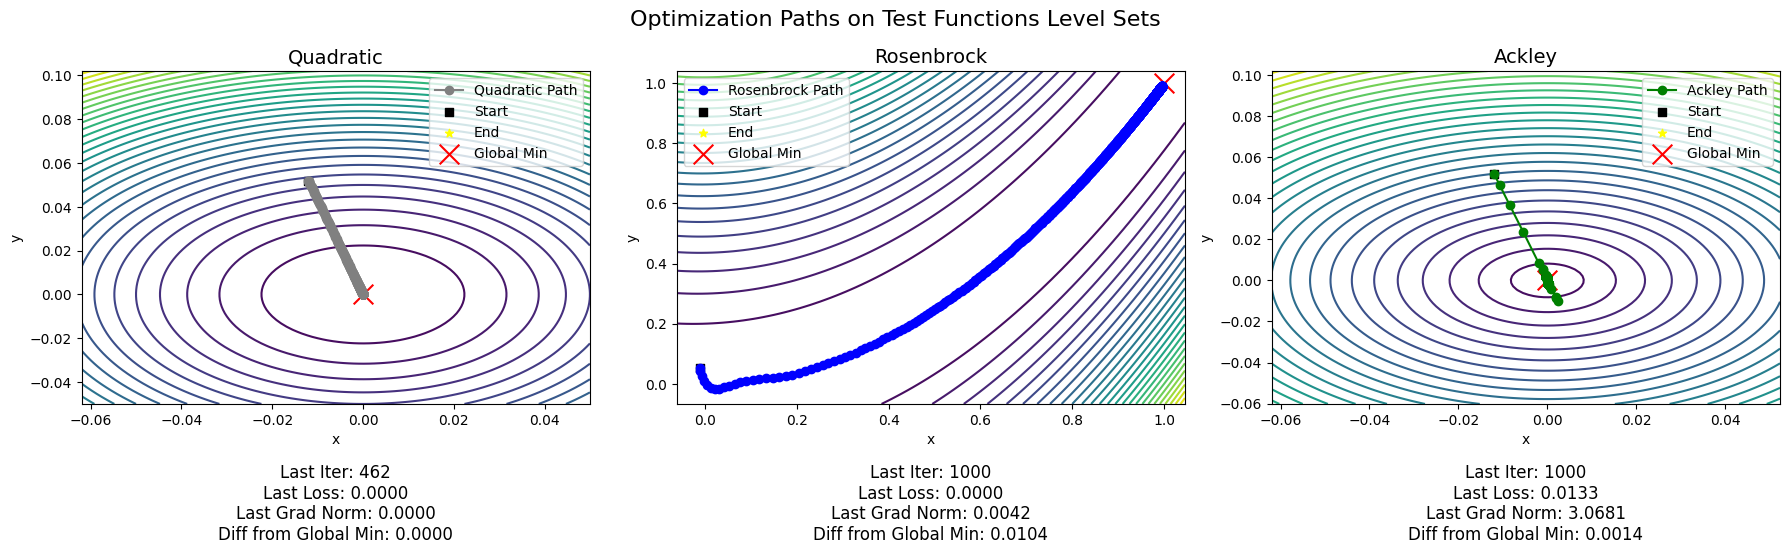

In [ ]:
# Create an instance of TestFunctions and test the optimizer
test_functions = TestFunctions()

# Set optimizer parameters
theta_init = np.array([-0.012, 0.052])
epsilon = 0.001  # Learning rate
eta = 0.9  # Momentum coefficient
tol = 1e-6
max_iters = 1000

# Define optimizer wrapper function for plotting
def optimizer_wrapper(f):
    _, history = NAG(f, theta_init, epsilon, eta, tol, max_iters)
    return history

# Plot the optimization paths for test functions
test_functions.plot_contours(optimizer_wrapper)

## Synthetic Data

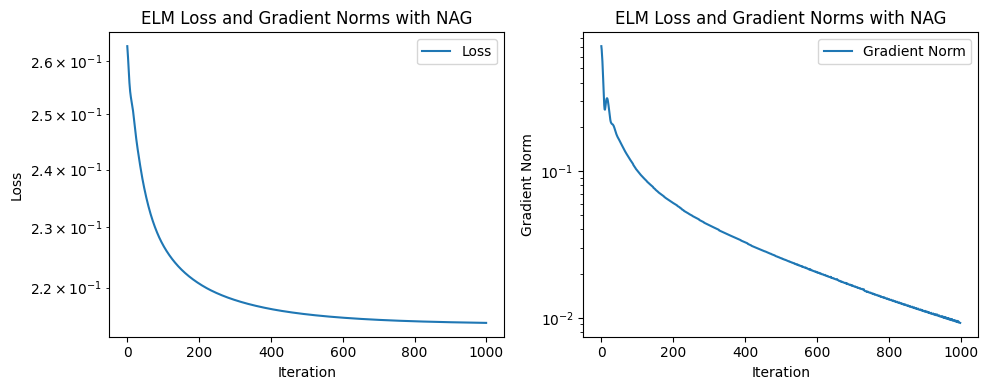

In [ ]:
model = ELM(input_size=X_syn.shape[1], hidden_size=100, output_size=1, l1_lambda=0.001, activation='relu', seed=42)

history = model.train(X_syn, y_syn, NAG, epsilon=1e-3, eta=0.9, tol=1e-6, max_iters=1000)
plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with NAG")

### Test Convergenza teorica

**Come funziona il codice**

1. **Dataset**:  
   - Generiamo dati $(X, y)$ di regressione lineare rumorosa (`X` in $\mathbb{R}^{N\times D}$, `y` in $\mathbb{R}^{N\times 1}$). (VEDI FUNZIONE SOPRA)
2. **ELM**:  
   - Creiamo un’ELM con 50 neuroni nascosti e attivazione `'relu'`.  
   - Impostiamo un valore molto piccolo di `l1_lambda` per non disturbare troppo la regolarizzazione ($\ell_1$) e rendere la funzione “quasi liscia”.  
3. **Ottimizzatore NAG**:  
   - Definiamo la funzione `NAG(...)` che usa la “look‐ahead” su $\theta + \eta v$.  
   - Creiamo dinamicamente un “optimizer” adatto alla firma `optimizer(f, theta_init) -> (theta_opt, history)`.  
   - La `ELM.train` si occupa di chiamare `f(theta)` (che aggiorna i pesi) e calcola loss + grad.  
4. **Loop sugli iperparametri**:  
   - Varia `epsilon_values = [0.001, 0.005, 0.01]` e `eta_values = [0.0, 0.5, 0.9, 0.99]`.  
   - Ogni volta, creiamo una copia “pulita” del modello e lo alleniamo. Salviamo la storia delle perdite.  
5. **Log‐log plot**:  
   - Calcoliamo il *relative gap* come $\frac{f(\theta^{(k)}) - f(\theta^*)}{|f(\theta^*)|}$.  
   - Tracciamo le curve per ogni coppia $(\epsilon, \eta)$.  
   - Tracciamo due **rette di riferimento**: $O(1/t)$ e $O(1/t^2)$.  

In questo modo puoi **verificare** se la convergenza per $\eta$ “alto” **si avvicina** a $O(1/t^2)$ (sempre tenendo conto che la presenza di $\ell_1$ anche se piccola introduce un po’ di non-liscezza) e se con $\eta=0$ ottieni un comportamento più vicino a $O(1/t)$.

In [ ]:
model_original = ELM(input_size=X_syn.shape[1], hidden_size=100, output_size=1, l1_lambda=1e-6, activation='relu', seed=42)

epsilon_values = [1e-4, 1e-3, 1e-2]
eta_values = [0.0, 0.1, 0.5, 0.8, 0.9, 0.99]   # 0 => GD classico, ~1 => NAG accelerato
max_iters = 5000
tol = 1e-8

In [ ]:
from copy import deepcopy

results = []

for eps in epsilon_values:
    for eta in eta_values:
        # Copia pulita del modello per ogni test
        model = deepcopy(model_original)

        # Alleniamo l'ELM
        history = model.train(X_syn, y_syn, NAG, epsilon = eps, eta = eta, tol = tol, max_iters = max_iters)

        # Salviamo i dati
        losses = np.array(history["losses"])
        # f* = loss minima (presa dall'ultima iter)
        f_star = losses[-1]
        # Gap relativo w.r.t. la prima iter (oppure w.r.t. f_star)
        # Qui usiamo f_star come offset => (f - f_star) / f_star
        rel_gap = (losses - f_star) / np.abs(f_star + 1e-15)  # per evitare zero division

        results.append({
            "epsilon": eps,
            "eta": eta,
            "losses": losses,
            "rel_gap": rel_gap
        })

Convergence reached based on gradient norm.


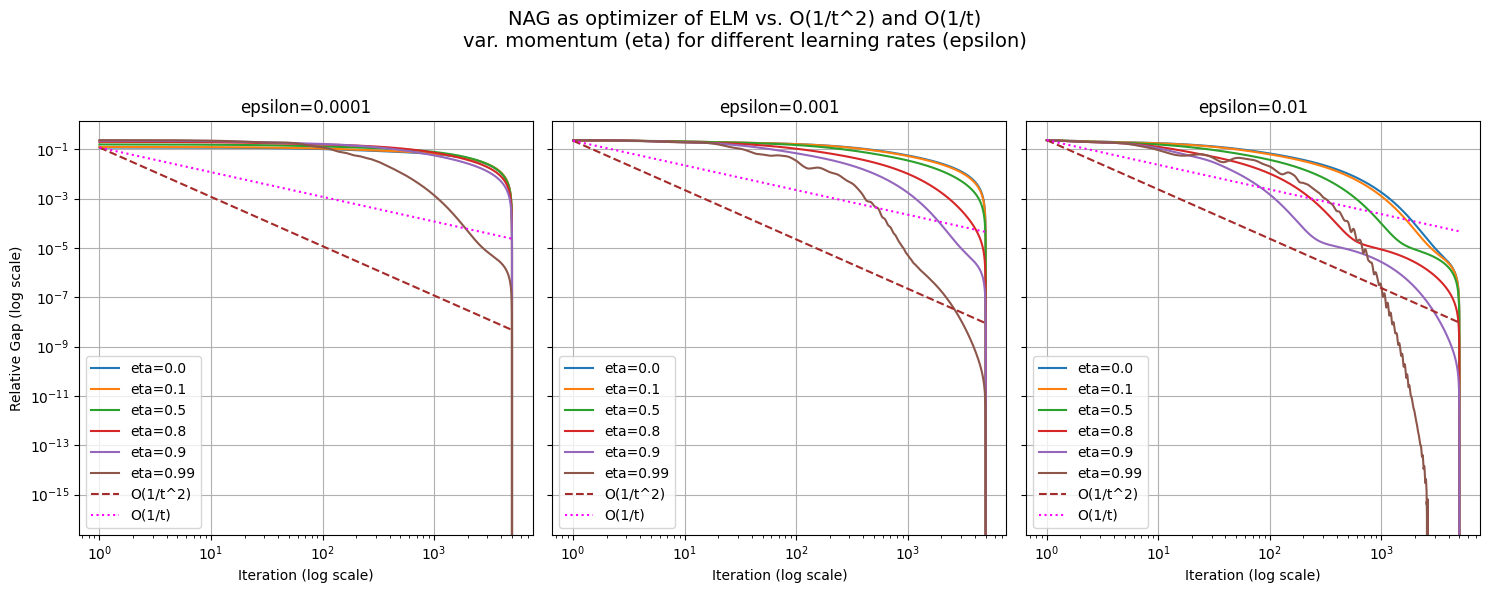

In [ ]:
num_eps = len(epsilon_values)
fig, axes = plt.subplots(1, num_eps, figsize=(5 * num_eps, 6), sharey=True)

for i, eps in enumerate(epsilon_values):
    ax = axes[i]

    # Filtriamo i risultati relativi a questo epsilon
    results_eps = [res for res in results if res["epsilon"] == eps]

    for res in results_eps:
        eta = res["eta"]
        rg = res["rel_gap"]
        iters = np.arange(1, len(rg) + 1)

        label = f"eta={eta}"
        ax.loglog(iters, rg, label=label)

    # Retta di riferimento O(1/t^2) e O(1/t)
    ref0 = results_eps[0]["rel_gap"][0]  # gap iniziale della prima run con eps corrente
    iters_ref = np.linspace(1, max_iters, 200)
    ref_1_over_t2 = ref0 / (iters_ref**2)
    ref_1_over_t = ref0 / iters_ref

    ax.loglog(iters_ref, ref_1_over_t2, '--', color='brown', label='O(1/t^2)')
    ax.loglog(iters_ref, ref_1_over_t, ':', color='magenta', label='O(1/t)')

    ax.set_xlabel("Iteration (log scale)")
    if i == 0:
        ax.set_ylabel("Relative Gap (log scale)")
    ax.set_title(f"epsilon={eps}")
    ax.legend()
    ax.grid(True)

# Titolo generale
plt.suptitle("NAG as optimizer of ELM vs. O(1/t^2) and O(1/t)\nvar. momentum (eta) for different learning rates (epsilon)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### GRID SEARCH FINALE per selezionare best configuration (per confronto con Smoothed)

In [ ]:
import time
epsilon_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
eta_values = [0.0, 0.1, 0.5, 0.8, 0.9, 0.95, 0.99]
max_iters = 5000
tol = 1e-6

best_score = float("inf")
best_params = None
best_history = None

for eps in epsilon_values:
    for eta in eta_values:
        # Costruiamo un modello pulito
        model = deepcopy(model_original)

        # Avviamo il training e misuriamo il tempo
        start_time = time.time()
        history = model.train(X_syn, y_syn, NAG, epsilon=eps, eta=eta, tol=tol, max_iters=max_iters)
        end_time = time.time()

        final_loss = history["losses"][-1]
        elapsed = end_time - start_time

        # Calcolo score: bilancia loss e tempo
        score = final_loss + elapsed

        # CRITERIO DI SELEZIONE: vogliamo il minimo score
        if score < best_score:
            best_score = score
            best_params = {
                "epsilon": eps,
                "eta": eta,
                "max_iters": max_iters,
                "elapsed": elapsed,
                "final_loss": final_loss,
                "score": score
            }

            best_history = history

print("\n=== Risultati Grid Search su NAG ===")
print(f"Miglior configurazione trovata: {best_params}")
print(f"Loss finale: {best_params['final_loss']}")
print(f"Tempo di esecuzione: {best_params['elapsed']} sec")
print(f"Score combinato: {best_params['score']}")

########################################
# 7) Salvataggio configurazione best
########################################
import json
with open("best_nag_config.json", "w") as f:
    json.dump(best_params, f, indent=2)

print("\nConfigurazione migliore di NAG salvata in 'best_nag_config.json'.")

Convergence reached based on gradient norm.
Convergence reached based on gradient norm.
Convergence reached based on gradient norm.
Stopping early due to unstable loss at iteration 18, loss: 36730100331.74053
Stopping early due to unstable loss at iteration 16, loss: 54960493307.76652
Stopping early due to unstable loss at iteration 12, loss: 57809116016.677216
Stopping early due to unstable loss at iteration 11, loss: 184633423744.73618
Stopping early due to unstable loss at iteration 10, loss: 23029002109.98165
Stopping early due to unstable loss at iteration 10, loss: 37180955871.27198
Stopping early due to unstable loss at iteration 10, loss: 53988385876.350586

=== Risultati Grid Search su NAG ===
Miglior configurazione trovata: {'epsilon': 0.01, 'eta': 0.99, 'max_iters': 5000, 'elapsed': 3.520108938217163, 'final_loss': np.float64(0.2108834854936876), 'score': np.float64(3.7309924237108505)}
Loss finale: 0.2108834854936876
Tempo di esecuzione: 3.520108938217163 sec
Score combinat

In [ ]:
"""
########################################
# 8) Esempio di utilizzo della config
########################################
# Se in un altro script vuoi confrontarti con un ottimizzatore differente:
#  1) Carichi i parametri
#  2) Definisci l'optimizer con questi param
#  3) Alleni lo stesso modello ELM e confronti

# Esempio di come ricaricare (qui lo rifacciamo subito):
with open("best_nag_config.json", "r") as f:
    config_loaded = json.load(f)

print("\nCaricata configurazione NAG:", config_loaded)

best_optimizer = make_optimizer_NAG(
    epsilon=config_loaded["epsilon"],
    eta=config_loaded["eta"],
    tol=config_loaded["tol"],
    max_iters=config_loaded["max_iters"]
)

# Confronto con un altro ottimizzatore "other_optimizer" (ipotetico):
# model_for_other = deepcopy(model_original)
# history_other = model_for_other.train(X, y, optimizer=other_optimizer)

# E poi potrai plottare le loss best_nag_config vs. other_optimizer per il confronto.
"""

'\n########################################\n# 8) Esempio di utilizzo della config\n########################################\n# Se in un altro script vuoi confrontarti con un ottimizzatore differente:\n#  1) Carichi i parametri\n#  2) Definisci l\'optimizer con questi param\n#  3) Alleni lo stesso modello ELM e confronti\n\n# Esempio di come ricaricare (qui lo rifacciamo subito):\nwith open("best_nag_config.json", "r") as f:\n    config_loaded = json.load(f)\n\nprint("\nCaricata configurazione NAG:", config_loaded)\n\nbest_optimizer = make_optimizer_NAG(\n    epsilon=config_loaded["epsilon"],\n    eta=config_loaded["eta"],\n    tol=config_loaded["tol"],\n    max_iters=config_loaded["max_iters"]\n)\n\n# Confronto con un altro ottimizzatore "other_optimizer" (ipotetico):\n# model_for_other = deepcopy(model_original)\n# history_other = model_for_other.train(X, y, optimizer=other_optimizer)\n\n# E poi potrai plottare le loss best_nag_config vs. other_optimizer per il confronto.\n'

Main findings:

1. **Effetto del learning rate $\epsilon$**  
   - Per $\epsilon = 10^{-4}$ (primo pannello) tutte le curve procedono lentamente verso valori bassi del gap. L’ordine di grandezza della convergenza è comunque buono, ma serve un numero di iterazioni più alto per arrivare a errori dell’ordine di $10^{-10}$ o minore.  
   - Per $\epsilon = 10^{-3}$ (secondo pannello) la discesa è più rapida: alcune curve (in particolare quelle con $\eta$ alto) raggiungono gap inferiori a $10^{-15}$ entro qualche centinaio di iterazioni.  
   - Per $\epsilon = 10^{-2}$ (terzo pannello) l’andamento inzialmente cala più rapidamente ma, a seconda di $\eta$, ci possono essere saturazioni o rallentamenti nella parte finale. Si notano comunque convergenze molto basse del gap, specialmente con momenti elevati, anche se in certi range di iterazione la discesa non è più regolare come nei casi con $\epsilon$ più piccolo.

2. **Effetto del coefficiente di momentum $\eta$**  
   - $\eta = 0$ (curva blu) corrisponde al *gradient descent classico* senza accelerazione, che converge decisamente più lentamente di tutte le varianti con momento.  
   - Aumentando $\eta$ — da 0.1 fino a 0.9 o 0.99 — si vede quasi sempre un miglioramento (le curve scendono più in fretta), specialmente appena dopo le prime iterazioni.  
   - I valori più alti di $\eta$ (0.9 o 0.99) tendono a dare le migliori prestazioni in termini di rapidità di discesa e valore finale del gap, anche se con $\epsilon$ grande ciò può talvolta produrre un iniziale overshoot o una fase finale meno “regolare”.

3. **Confronto con le reference $O(1/t^2)$ e $O(1/t)$**  
   - Le linee tratteggiate e puntinate servono a confrontare empiricamente la velocità di discesa con i due tassi di convergenza tipici di metodi “accelerati” $(1/t^2)$ e di quelli base $(1/t)$.  
   - Si nota che, specialmente con $\eta$ elevato e $\epsilon$ adeguato, la curva della funzione obiettivo segue un declino vicino o persino più rapido di $O(1/t)$ e in parte si avvicina o sovrasta la retta $O(1/t^2)$, coerentemente con l’effetto di accelerazione introdotto da Nesterov.

In sintesi, **i risultati evidenziano che valori alti di momentum ($\eta\approx 0.9$ o 0.99) abbinati a un learning rate sufficientemente grande (ma non troppo) producono in generale la discesa più rapida e il minor gap finale**. Se $\epsilon$ è troppo basso la convergenza è sicura ma lenta, mentre se è troppo alto si rischiano instabilità (o oscillazioni) prima di convergere. Le curve confermano il beneficio dell’“accelerazione” di NAG rispetto al GD classico ($\eta=0$) e mostrano come la velocità di convergenza effettiva possa avvicinarsi all’andamento teorico $O(1/t^2)$ per scelte opportune di $\eta$ ed $\epsilon$.

### Test Lambda diversi

1. **Salvare l'intera history del training** (non solo l'ultimo valore di loss).  
2. **Selezionare la combinazione $(\lambda, \epsilon, \eta)$** migliore per ogni $\lambda$ in base al tuo criterio (ad esempio lo `score` o la `final_loss`).  
3. **Plottare il “gap relativo” in scala log‐lineare** rispetto al numero di iterazioni, in modo da confrontare la convergenza per i vari valori di $\lambda$.  

L’idea è che per ciascun $\lambda$ tu ricostruisca (o conservi) l’andamento della loss a ogni iterazione (la cosiddetta *history*), prenda la loss finale come riferimento ($f^*$) e calcoli
$$
\text{gap_relativo}(k) = \frac{f(\mathbf{w}^{(k)}) - f^*}{f^*},
$$
dove $f(\mathbf{w}^{(k)})$ è la loss all’iterazione $k$ e $f^*$ è la loss finale raggiunta dalla stessa run.  



In questo modo, in `results` avrai per ogni tripla $(\lambda, \epsilon, \eta)$ anche la lista completa di tutte le `losses` in ogni iterazione.



**Calcolo e plot del gap relativo in scala log-lineare**

Ora possiamo plottare il “gap relativo” $\frac{f(w_k) - f^*}{f^*}$ per ogni $\lambda$. L'idea è:

- Selezionare, per ciascun $\lambda$, **la combinazione migliore** (ad esempio quella con miglior `score`, oppure miglior `final_loss`).
- Prelevare la relativa `history` (i valori di loss a ogni iterazione).
- Calcolare la loss finale $\min_k f(w_k)$ o semplicemente la loss all’ultima iterazione `final_loss`.
- Costruire il gap relativo e plottarlo in scala logaritmica sull’asse delle y (log-linear).

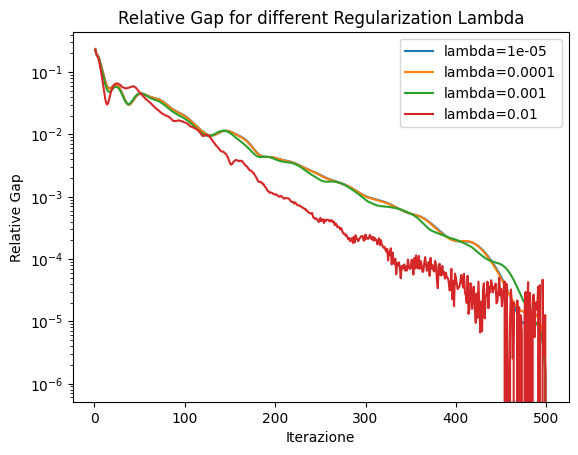

In [ ]:
import matplotlib.pyplot as plt
import time

l1_values = [1e-5, 1e-4, 1e-3, 1e-2]
epsilon = 0.01
eta = 0.99
max_iters = 500

plt.figure()

for l1_lambda in l1_values:
    model = ELM(input_size=X_syn.shape[1], hidden_size=100, output_size=1, l1_lambda=l1_lambda, activation='relu', seed=42)

    start_time = time.time()
    history = model.train(X_syn, y_syn, NAG, epsilon=epsilon, eta=eta, tol=1e-6, max_iters=max_iters)
    end_time = time.time()

    final_loss = history['losses'][-1]  # ultima loss
    num_iterations = len(history['losses'])
    time_taken = end_time - start_time

    losses = history['losses']
    # Gap relativo rispetto alla loss finale (o potresti usare la minima loss trovata)
    relative_gap = [(loss - final_loss) / final_loss for loss in losses]

    # semilogy = asse y in scala log, asse x lineare
    plt.semilogy(range(1, len(relative_gap) + 1), relative_gap, label=f"lambda={l1_lambda}")

plt.xlabel("Iterazione")
plt.ylabel("Relative Gap")
plt.title("Relative Gap for different Regularization Lambda")
plt.legend()
plt.show()

In questo grafico:

- Sull’**asse x** hai il numero di iterazioni.
- Sull’**asse y** (in scala logaritmica) il gap relativo $\frac{f(w_k) - f^*}{f^*}$.  
- Confronti quindi le diverse curve (una per ogni $\lambda$), interpretandone la pendenza e la velocità con cui scendono verso il valore finale.

In questo modo hai una rappresentazione *log‐lineare* che mette in evidenza come (e quanto rapidamente) la loss scende al variare di $\lambda$, rendendo più semplice il confronto di convergenza rispetto a plottare direttamente le loss (che magari si trovano su scale diverse a causa dell’effetto di regolarizzazione).

Si nota che per valori più elevati di $\lambda$, pur avendo una discesa più veloce iniziale, alla fine compaiono evidenti oscillazioni, suggerendo una difficoltà nel trovare un equilibrio stabile. Questo potrebbe essere dovuto all'effetto della regolarizzazione L1, che forza i pesi verso zero, causando una maggiore variabilità nei gradienti e rendendo più irregolare la convergenza.

## California Housing

In [ ]:
'''# Definisci lo spazio di ricerca
l1_values = [1e-5, 1e-4, 1e-3, 1e-2]
epsilon_values = [1e-4, 1e-3, 1e-2]
eta_values = [0.0, 0.1, 0.5, 0.8, 0.9, 0.99]

# Esegui la ricerca
best_params, search_results = grid_search_elm(X_cal, y_cal, l1_values, epsilon_values, eta_values)

print(f"BEST PARAMS:")
print(f"l1_lambda={best_params[0]}, epsilon={best_params[1]}, eta={best_params[2]}")'''

'# Definisci lo spazio di ricerca\nl1_values = [1e-5, 1e-4, 1e-3, 1e-2]\nepsilon_values = [1e-4, 1e-3, 1e-2]\neta_values = [0.0, 0.1, 0.5, 0.8, 0.9, 0.99]\n\n# Esegui la ricerca\nbest_params, search_results = grid_search_elm(X_cal, y_cal, l1_values, epsilon_values, eta_values)\n\nprint(f"BEST PARAMS:")\nprint(f"l1_lambda={best_params[0]}, epsilon={best_params[1]}, eta={best_params[2]}")'

In [ ]:
'''import matplotlib.pyplot as plt

plt.figure()

for l1_lambda in l1_values:
    # Filtra i risultati relativi a questo l1_lambda
    lambda_results = [res for res in search_results if res['l1_lambda'] == l1_lambda]

    # Seleziona la run "migliore" in base allo score (o 'final_loss')
    best_run = min(lambda_results, key=lambda x: x['score'])

    # Estraggo l'history: vettore delle loss per iterazione
    losses = best_run['history']
    final_loss = losses[-1]  # all'ultima iterazione

    # Gap relativo rispetto alla loss finale (o potresti usare la minima loss trovata)
    relative_gap = [(loss - final_loss) / final_loss for loss in losses]

    # semilogy = asse y in scala log, asse x lineare
    plt.semilogy(range(1, len(relative_gap) + 1), relative_gap, label=f"lambda={l1_lambda}")

plt.xlabel("Iterazione")
plt.ylabel("Relative Gap")
plt.title("Confronto convergenza per diversi valori di lambda")
plt.legend()
plt.show()'''

'import matplotlib.pyplot as plt\n\nplt.figure()\n\nfor l1_lambda in l1_values:\n    # Filtra i risultati relativi a questo l1_lambda\n    lambda_results = [res for res in search_results if res[\'l1_lambda\'] == l1_lambda]\n\n    # Seleziona la run "migliore" in base allo score (o \'final_loss\')\n    best_run = min(lambda_results, key=lambda x: x[\'score\'])\n\n    # Estraggo l\'history: vettore delle loss per iterazione\n    losses = best_run[\'history\']\n    final_loss = losses[-1]  # all\'ultima iterazione\n\n    # Gap relativo rispetto alla loss finale (o potresti usare la minima loss trovata)\n    relative_gap = [(loss - final_loss) / final_loss for loss in losses]\n\n    # semilogy = asse y in scala log, asse x lineare\n    plt.semilogy(range(1, len(relative_gap) + 1), relative_gap, label=f"lambda={l1_lambda}")\n\nplt.xlabel("Iterazione")\nplt.ylabel("Relative Gap")\nplt.title("Confronto convergenza per diversi valori di lambda")\nplt.legend()\nplt.show()'

In [24]:
model_original = ELM(input_size=X_cal.shape[1], hidden_size=100, output_size=1, l1_lambda=1e-6, activation='relu', seed=42)

epsilon_values = [1e-4, 1e-3, 1e-2]
eta_values = [0.0, 0.1, 0.5, 0.8, 0.9, 0.99]   # 0 => GD classico, ~1 => NAG accelerato
max_iters = 5000
tol = 1e-8

In [25]:
from copy import deepcopy

results = []

for eps in epsilon_values:
    for eta in eta_values:
        # Copia pulita del modello per ogni test
        model = deepcopy(model_original)

        # Alleniamo l'ELM
        history = model.train(X_cal, y_cal, NAG, epsilon = eps, eta = eta, tol = tol, max_iters = max_iters)

        # Salviamo i dati
        losses = np.array(history["losses"])
        # f* = loss minima (presa dall'ultima iter)
        f_star = losses[-1]
        # Gap relativo w.r.t. la prima iter (oppure w.r.t. f_star)
        # Qui usiamo f_star come offset => (f - f_star) / f_star
        rel_gap = (losses - f_star) / np.abs(f_star + 1e-15)  # per evitare zero division

        results.append({
            "epsilon": eps,
            "eta": eta,
            "losses": losses,
            "rel_gap": rel_gap
        })

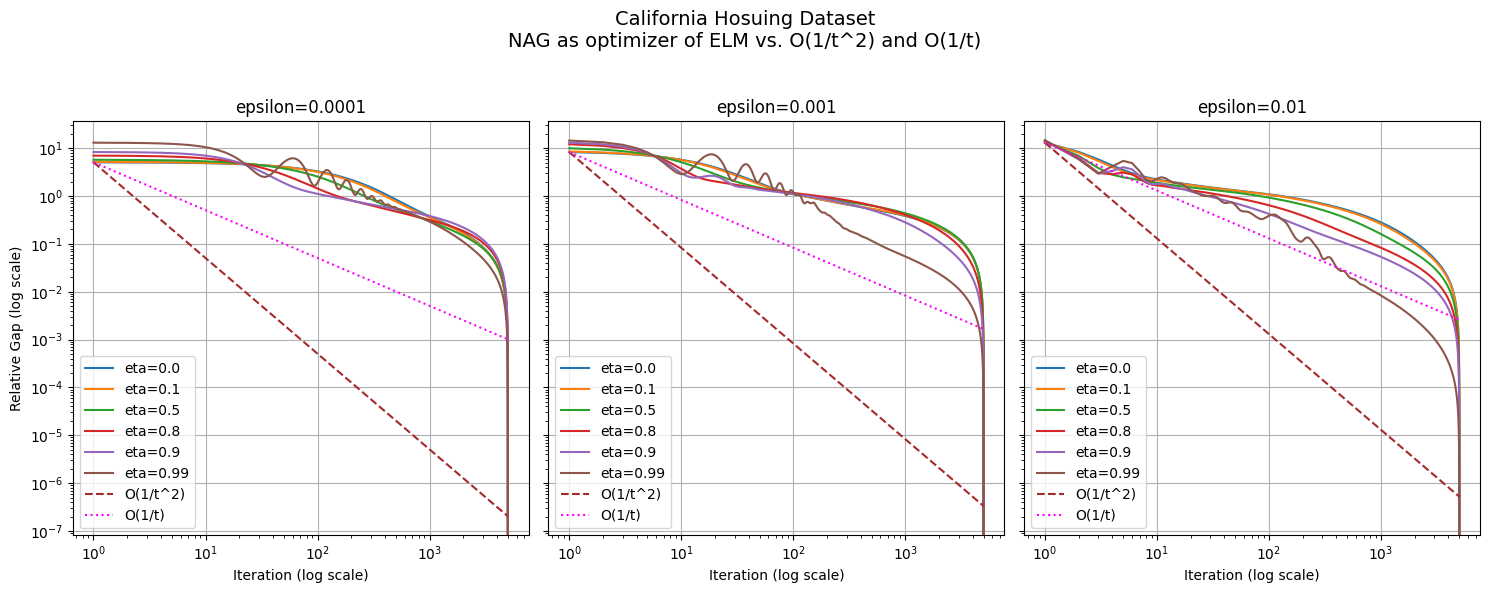

In [26]:
num_eps = len(epsilon_values)
fig, axes = plt.subplots(1, num_eps, figsize=(5 * num_eps, 6), sharey=True)

for i, eps in enumerate(epsilon_values):
    ax = axes[i]

    # Filtriamo i risultati relativi a questo epsilon
    results_eps = [res for res in results if res["epsilon"] == eps]

    for res in results_eps:
        eta = res["eta"]
        rg = res["rel_gap"]
        iters = np.arange(1, len(rg) + 1)

        label = f"eta={eta}"
        ax.loglog(iters, rg, label=label)

    # Retta di riferimento O(1/t^2) e O(1/t)
    ref0 = results_eps[0]["rel_gap"][0]  # gap iniziale della prima run con eps corrente
    iters_ref = np.linspace(1, max_iters, 200)
    ref_1_over_t2 = ref0 / (iters_ref**2)
    ref_1_over_t = ref0 / iters_ref

    ax.loglog(iters_ref, ref_1_over_t2, '--', color='brown', label='O(1/t^2)')
    ax.loglog(iters_ref, ref_1_over_t, ':', color='magenta', label='O(1/t)')

    ax.set_xlabel("Iteration (log scale)")
    if i == 0:
        ax.set_ylabel("Relative Gap (log scale)")
    ax.set_title(f"epsilon={eps}")
    ax.legend()
    ax.grid(True)

# Titolo generale
plt.suptitle("California Hosuing Dataset\nNAG as optimizer of ELM vs. O(1/t^2) and O(1/t)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Smoothed

In principle $M$, being the Lipshitz constant of the gradient of the smooth part of the function (in our case the MSE component), can be estimated through the maximum eigenvalue of the Hessian matrix. In the neural network case of this problem, the Hessian with respect to $W_2$ would be $$\nabla^2 \bigl\|W_2\sigma(W_1 x) - y\bigr\|^2$$ and $M$ would correspond to its maximum value. To explicitly determine the constant $M$ (Lipschitz constant of the gradient of the quadratic part) it is sufficient to calculate the maximum eigenvalue of the Hessiana of the function $\|W_2\sigma(W_1x) - y\|^2$ with respect to $W_2$. If in the problem we have:

- $N$ samples $\{x_i,y_i\}_{i=1}^N$,
- $W_1\in\mathbb{R}^{L\times d}$ (weights _fixed_ input$\to$hidden),
- $\sigma(\cdot)$ activation (here taken as an element-wise function),
- $W_2\in\mathbb{R}^{L\times m}$ (towable weights hidden$\to$output),
- $H\in\mathbb{R}^{N\times L}$ the matrix stacking the hidden features (row $i$ corresponding to $\sigma(W_1x_i)$),

then the smooth part to be optimized is:
$$
g(W_2)\;=\;\bigl\|\,H\,W_2^\top \;-\;Y\,\bigr\|_F^{2}
\quad\text{(if }m>1\text{, otherwise }\|HW_2 - y\|^2 \text{).}
$$
The Hessian matrix of $g$ with respect to $W_2$ (in the case $m=1$ for simplicity) results:
$$
\nabla^2 g(W_2)\;=\;2\,H^\top\,H,
$$
and thus the maximum eigenvalue of $\nabla^2 g(W_2)$ is $2\,\lambda_{\max}(H^\top\ H)$. But $\lambda_{\max}(H^\top H)$ is precisely the square of the singular maximum of $H$, that is, $\sigma_{\max}(H)^2$. Therefore, the Lipschitz constant $M$ (which governs the “curvature” of $g$) is
$$
\boxed{\,M \;=\; 2\,\|H\|_{2}^{2}\;=\;2\,\bigl(\sigma_{\max}(H)\bigr)^2.}
$$

Where $\|H\|_{2}$ is the spectral norm (or singular maximum) of $H$. In other words:
1. Construct $H$ (dimension $N\times L$), whose elements are $H_{i,:} = \sigma(W_1 x_i)$.
2. Run SVD (or eigenvalues of $H^\top H$) to find $\sigma_{\max}(H)$.
3. Calculate $M = 2\,\sigma_{\max}(H)^2$.

In [7]:
# ---------------------------------------------------------
# Compute Lipschitz constant of MSE
# ---------------------------------------------------------
def compute_mse_lipschitz_constant(model, X):
    """
    Calcola la costante di Lipschitz M dell'MSE
    (parte smooth della loss):
      M = (sigma_max(H)^2) / n_samples
    dove H = activation(X.dot(weights_input_hidden)+bias_hidden).

    Parameters:
    X: np.ndarray, shape (n_samples, input_size)
      Input data.

    Returns:
    M: float
      Lipschitz constant.
    """
    # 1) Calcolo H
    hidden_inp = X.dot(model.weights_input_hidden) + model.bias_hidden
    H = model.activation(hidden_inp)  # shape: (n_samples, hidden_size)

    # 2) Calcolo singolare massima di H
    sigma_max = np.linalg.norm(H, ord=2)  # massima singolare (norma spettrale)

    # 3) Definisco M
    n_samples = X.shape[0]
    M = (sigma_max**2) / n_samples

    return M

According to Theorem 3 in \cite{Nesterov2005}, the smoothing parameter $\mu$ should be chosen as:

$$
\mu = \frac{2 \|A\|_{1,2}}{N+1} \sqrt{\frac{D_1}{\sigma_1 \sigma_2 D_2}}
$$

where:
- $\|A\|_{1,2}$ is the operator norm of $A$.
- $N$ is the number of iterations.
- $D_1$ and $D_2$ relate to prox-functions and feasible set diameters.
- $\sigma_1$ and $\sigma_2$ are convexity parameters of prox-functions.


- The theoretical formula suggests that $\mu$ **decreases with the number of iterations** $N$ to ensure better approximation.
- The formula depends on **both convexity parameters** $\sigma_1$ and $\sigma_2$, while the implementation only considers $\sigma_2$.
- The **diameters** $D_1, D_2$ are absent, which means the impact of feasible region size is ignored.

To correctly compute $\mu$:

```python
if mu is None:
    mu = (2 * A_norm / (epochs + 1)) * np.sqrt(D1 / (sigma_1 * sigma_2 * D2))
```

where:
- `D1`, `D2` should be estimated or computed from the problem structure.
- `sigma_1`, `sigma_2` should be correctly set.

To correctly estimate $D_1$, $D_2$, $\sigma_1$, and $\sigma_2$, we need to consider their definitions from Nesterov’s framework.


The parameters come from the prox-functions and feasible sets:

- **$D_1$ and $D_2$ (Diameters of the prox-sets)**  
  - $D_1 = \max_{x} d_1(x)$ over $Q_1$ (the domain of $x$).  
  - $D_2 = \max_{u} d_2(u)$ over $Q_2$ (the domain of $u$).  
  - These capture how "large" the feasible region is in terms of distance.

- **$\sigma_1$ and $\sigma_2$ (Strong convexity parameters of the prox-functions)**  
  - $\sigma_1$ is the strong convexity parameter of $d_1(x)$ over $Q_1$.  
  - $\sigma_2$ is the strong convexity parameter of $d_2(u)$ over $Q_2$.  
  - These indicate how strongly convex the prox-functions are, which influences the rate of convergence.


From the smoothing theory, the prox-functions $d_1(x)$ and $d_2(u)$ are typically chosen as **log-barriers or quadratic distance functions**. Common choices include:

**Quadratic prox-function: $d(x) = \frac{1}{2} \| x - x_0 \|^2$**
- If $d_1(x) = \frac{1}{2} \| x - x_0 \|^2$, then:
  $$
  D_1 = \max_{x \in Q_1} \| x - x_0 \|^2
  $$
  which is the **square of the Euclidean diameter** of $Q_1$.

- Similarly, if $d_2(u) = \frac{1}{2} \| u - u_0 \|^2$, then:
  $$
  D_2 = \max_{u \in Q_2} \| u - u_0 \|^2
  $$
  which is the **square of the Euclidean diameter** of $Q_2$.

- In the ELM setting:
  - $Q_1$ (the feasible set of $x$) is typically **bounded by a norm constraint**.
  - $Q_2$ (the feasible set of $u$) depends on the dual structure.


If using a quadratic prox-function $d(x) = \frac{1}{2} \| x - x_0 \|^2$, then:
  $$
  \sigma = 1
  $$
for both parameters, since quadratic functions have strong convexity parameter 1.


**Conclusion**
- $D_1$ and $D_2$ can be computed as the **maximum pairwise Euclidean distance** within $Q_1$ and $Q_2$.
- $\sigma_1 = \sigma_2 = 1.0$ if using quadratic prox-functions.
- If different prox-functions are used, convexity parameters should be computed from their Hessians.

This ensures that $\mu$ is now computed correctly in accordance with Nesterov's theory.

In [8]:
def compute_diameter(Q):
    """Estimate the diameter of a set Q (max pairwise Euclidean distance)."""
    return np.max(np.linalg.norm(Q[:, None, :] - Q[None, :, :], axis=-1))

In [9]:
def smoothed(
    f,
    theta_init,
    A_norm,
    D1,
    D2,
    sigma_1,
    sigma_2,
    epochs=1000,
    M=None,
    mu=None,
    nu = None,
    momentum_init=0.9,
    gradient_norm_threshold=None
):
    """
    Smoothed optimization using Nesterov's smoothing.

    Parameters:
    - f: objective function returning (loss, gradient, _)
    - theta_init: initial parameter vector
    - A_norm: spectral norm of matrix A ( ||A||_{1,2} )
    - D1: max value of prox-function d1 over Q1
    - D2: max value of prox-function d2 over Q2
    - sigma_1: convexity parameter for Q1 prox-function
    - sigma_2: convexity parameter for Q2 prox-function
    - epochs: number of iterations
    - M: Lipschitz constant of smooth part (if None, computed)
    - mu: smoothing parameter (if None, computed from theory)
    - momentum_init: momentum coefficient
    - gradient_norm_threshold: stopping criterion based on gradient norm

    Returns:
    - theta: optimized parameters
    - history: dict of loss and gradients per iteration
    """

    assert A_norm > 0, "A_norm must be positive."
    assert D1 > 0 and D2 > 0, "D1 and D2 must be positive."
    assert sigma_1 > 0 and sigma_2 > 0, "sigma_1 and sigma_2 must be positive."

    # 1) Compute smoothing parameter μ if not provided
    if mu is None:
      mu = (2 * A_norm / (epochs + 1)) * np.sqrt(D1 / (sigma_1 * sigma_2 * D2))

    assert mu > 0, "Computed μ must be positive."

    # 2) Compute Lipschitz constant L_L1
    L_L1 = (1.0 / (mu * sigma_2)) * A_norm

    # 3) Compute overall Lipschitz constant L_mu
    if M is None:
      # Estimate Lipschitz constant M if not provided
      M = L_L1  # Placeholder, should be computed separately if needed

    L_mu = M + L_L1
    if nu is None:
      nu = 1.0 / L_mu  # Learning rate

    print("------ PARAMETERS ------")
    print(f"M = {M}")
    print(f"D1 = {D1}, D2 = {D2}")
    print(f"sigma_1 = {sigma_1}, sigma_2 = {sigma_2}")
    print(f"mu = {mu}")
    print(f"L_L1 = {L_L1}")
    print(f"L_mu = {L_mu}")
    print(f"nu (learning rate) = {nu}")
    print("------------------------")

    # Initialize momentum and parameters
    v = np.zeros_like(theta_init)
    theta = theta_init.copy()
    eta = momentum_init

    history = {"losses": [], "grad_norms": [], "trajectory": [theta.copy()]}

    for epoch in range(epochs):
        theta_look = theta + eta * v
        loss, grad, _ = f(theta_look)
        gn = np.linalg.norm(grad)

        history["losses"].append(loss)
        history["grad_norms"].append(gn)

        if gradient_norm_threshold is not None and gn < gradient_norm_threshold:
            print(f"Stopping early at epoch {epoch}, grad norm < {gradient_norm_threshold}")
            break

        # Momentum update
        v = eta * v - nu * grad
        theta = theta + v
        history["trajectory"].append(theta.copy())

    return theta, history

------ PARAMETERS ------
M = 0.12690283837749194
D1 = 5.471891793988954, D2 = 1.627454884132169
sigma_1 = 1.0, sigma_2 = 1.0
mu = 0.00183272446956251
L_L1 = 545.6357551873087
L_mu = 545.7626580256863
nu (learning rate) = 0.0018322983173996031
------------------------
Stopping early at epoch 188, grad norm < 1e-06
------ PARAMETERS ------
M = 0.11514523437013374
D1 = 5.460155954320693, D2 = 1.5681826099982257
sigma_1 = 1.0, sigma_2 = 1.0
mu = 0.00186503554773408
L_L1 = 536.1828096064696
L_mu = 536.2979548408398
nu (learning rate) = 0.0018646351174260503
------------------------
------ PARAMETERS ------
M = 0.7577208635025452
D1 = 13.8425084281829, D2 = 3.8968314397221024
sigma_1 = 1.0, sigma_2 = 1.0
mu = 0.0018837987097069706
L_L1 = 530.8422788736024
L_mu = 531.5999997371049
nu (learning rate) = 0.001881113620192881
------------------------


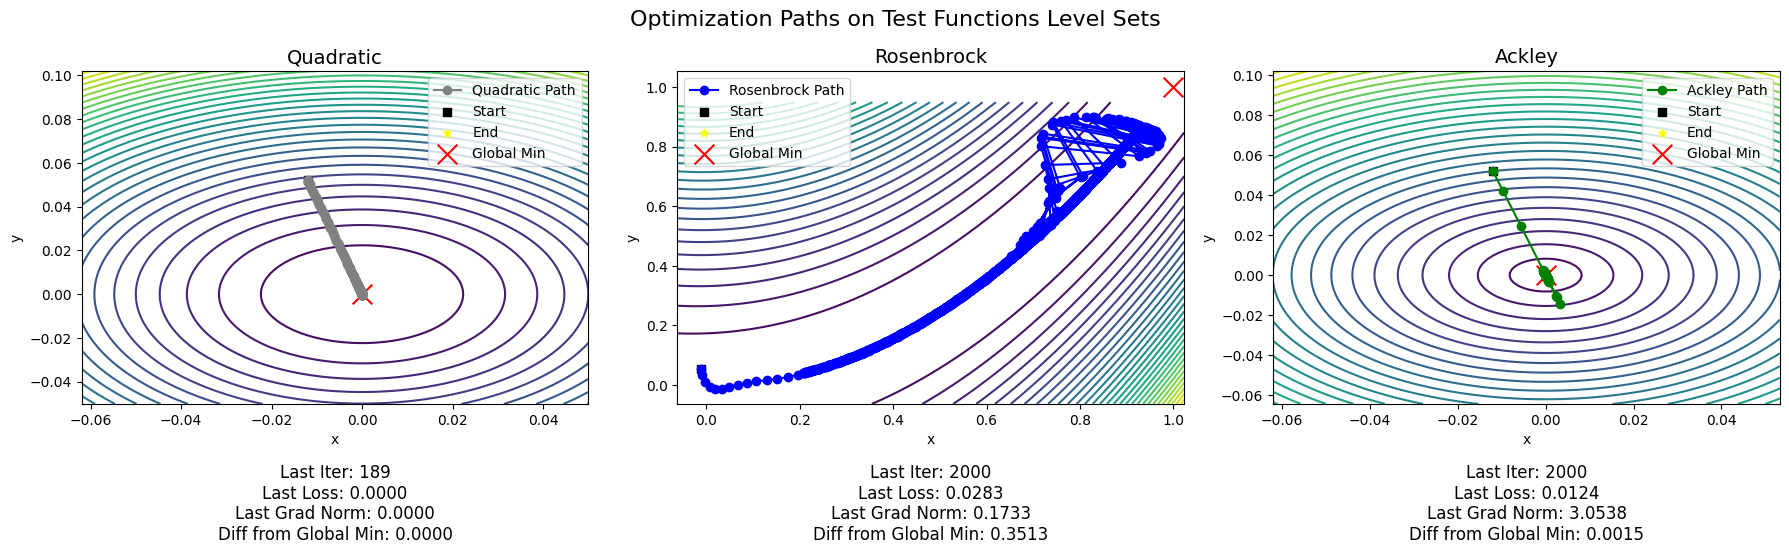

In [ ]:
elm_model = ELM(input_size=2, hidden_size=50, output_size=1, l1_lambda=0.01, activation='relu')

def sample_input_space(f, num_samples=500):
    """
    Generates a synthetic input dataset matching the test function’s domain.
    """
    domain_bounds = {
        "quadratic": np.array([[-2, -2], [2, 2]]),
        "rosenbrock": np.array([[-2, -2], [2, 2]]),
        "ackley": np.array([[-5, -5], [5, 5]])
    }
    bounds = domain_bounds.get(f.__name__, np.array([[-2, -2], [2, 2]]))

    return np.random.uniform(bounds[0, 0], bounds[1, 0], size=(num_samples, bounds.shape[1]))

##################################################
# 2) Initialize ELM Model
##################################################

elm_model = ELM(input_size=2, hidden_size=50, output_size=1, l1_lambda=0.01, activation='tanh')

##################################################
# 3) Smoothed Optimizer Wrapper
##################################################

A_norm = 1.0  # Spectral norm ||A||
sigma_1, sigma_2 = 1.0, 1.0  # Strong convexity parameters
theta_init = np.array([-0.012, 0.052])  # Initial parameter guess
epochs = 2000
momentum_init = 0.9
gradient_norm_threshold = 1e-6

def smoothed_optimizer_wrapper(f):
    """
    Wrapper to run the smoothed optimizer on different test functions.
    Ensures D1, M, and D2 are computed dynamically for each function.
    """
    X_test = sample_input_space(f, num_samples=500)  # Generate function input space
    D1 = compute_diameter(X_test)  # Compute correct D1
    M = compute_mse_lipschitz_constant(elm_model, X_test)  # Compute M dynamically

    # Compute D2 using ELM's hidden layer transformation
    hidden_repr = elm_model.activation(X_test @ elm_model.weights_input_hidden + elm_model.bias_hidden)
    D2 = compute_diameter(hidden_repr)  # Hidden space diameter

    _, history = smoothed(
        f,
        theta_init,
        A_norm,
        epochs=epochs,
        D1=D1,
        D2=D2,
        M=M,
        sigma_1=sigma_1,
        sigma_2=sigma_2,
        momentum_init=momentum_init,
        gradient_norm_threshold=gradient_norm_threshold
    )
    return history

##################################################
# 4) Run the Optimizer on Test Functions
##################################################
test_functions = TestFunctions()
test_functions.plot_contours(smoothed_optimizer_wrapper)

## Synthetic dataset

In [ ]:
# Step 1: Generate synthetic dataset
X_syn, y_syn = generate_synthetic_regression_data(n_samples=1000, n_features=100, noise=0.1, random_seed=42)

# Step 2: Initialize the ELM model
elm_model = ELM(input_size=100, hidden_size=50, output_size=1, l1_lambda=0.01, activation='tanh')

# Step 3: Compute necessary parameters for the smoothed optimizer
A_norm = 1.0  # Spectral norm ||A|| -> in questo caso A è la matrice identità, quindi A_norm = 1.0
D1 = compute_diameter(X_syn)  # Diameter of Q1 (input space)
hidden_repr = elm_model.activation(X_syn @ elm_model.weights_input_hidden + elm_model.bias_hidden)
D2 = compute_diameter(hidden_repr)  # Diameter of Q2 (hidden representation)
sigma_1, sigma_2 = 1.0, 1.0  # Strong convexity parameters (default 1.0 for quadratic prox)
M = compute_mse_lipschitz_constant(elm_model, X_syn)  # Lipschitz constant for MSE

# Step 4: Train the model using `smoothed` as the optimizer
history = elm_model.train(
    X_syn, y_syn,
    optimizer=smoothed,  # Pass smoothed as optimizer
    A_norm=A_norm,
    D1=D1,
    D2=D2,
    sigma_1=sigma_1,
    sigma_2=sigma_2,
    M=M,
    epochs=500,
    momentum_init=0.9,
    gradient_norm_threshold=1e-4  # Stop early if grad norm < threshold
)

# Step 5: Print final loss
print(f"Initial training loss: {history['losses'][0]:.6f}")
print(f"Final training loss: {history['losses'][-1]:.6f}")

------ PARAMETERS ------
M = 0.13814365484151395
D1 = 17.683862918880553, D2 = 3.460919796590023
sigma_1 = 1.0, sigma_2 = 1.0
mu = 0.009023708803502424
L_L1 = 110.81917887375357
L_mu = 110.95732252859509
nu (learning rate) = 0.009012474140607418
------------------------
Initial training loss: 0.257840
Final training loss: 0.237263


Rank di H: 200 su 200
Sigma2: 65.86032790885194
Lipschitz constant: 64.41782006534523
------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.683862918880553, D2 = 22.57156788452081
sigma_1 = 1.0, sigma_2 = 65.86032790885194
mu = 0.00021791728526345184
L_L1 = 69.67619586954409
L_mu = 134.0940159348893
nu (learning rate) = 0.0074574543317843505
------------------------


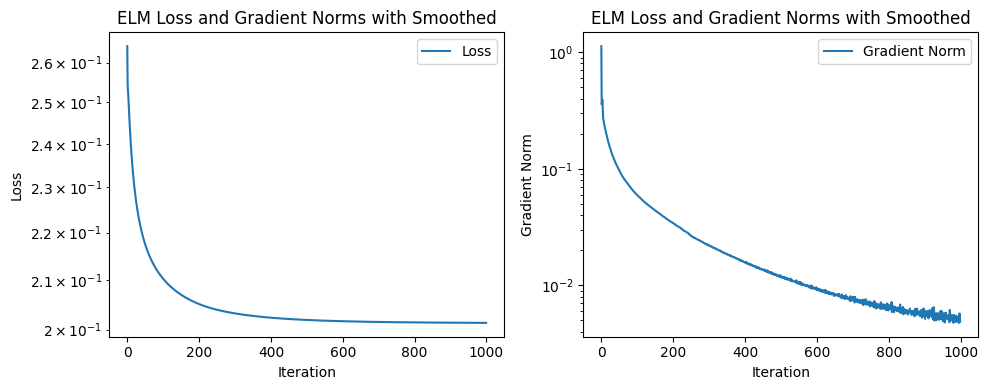

In [ ]:
model = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)

# 1) Compute the hidden activation matrix once
model.forward(X_syn)
H = model.hidden_layer_output  # shape (N, hidden_size)
rank_H = np.linalg.matrix_rank(H)
print(f"Rank di H: {rank_H} su {H.shape[1]}")

'''
A_norm = np.linalg.norm(H, ord=2)**2  # largest singular value squared

This is correct if you consider smoothing the gradient of the MSE loss, where A corresponds to the hidden layer activation matrix H.
However, for the smoothing of the L1-norm, you should use A_norm = 1 because A is the identity matrix for the L1 norm smoothing
'''

# Step 3: Compute necessary parameters for the smoothed optimizer
A_norm = 1.0  # Spectral norm ||A|| -> in questo caso A è la matrice identità, quindi A_norm = 1.0
D1 = compute_diameter(X_syn)  # Diameter of Q1 (input space)
hidden_repr = model.activation(X_syn @ model.weights_input_hidden + model.bias_hidden)
D2 = compute_diameter(hidden_repr)  # Diameter of Q2 (hidden representation)
sigma_1= 1.0  # Strong convexity parameters (default 1.0 for quadratic prox)
M = compute_mse_lipschitz_constant(model, X_syn)  # Lipschitz constant for MSE
sigma_2 = np.min(np.linalg.eigvals(H.T @ H))  # H.T @ H è quadrata di dim (hidden_size, hidden_size); # strong convexity parameter: minimo autovalore dell'Hessiana
print(f'Sigma2: {sigma_2}')
print(f"Lipschitz constant: {M}")

history = model.train(
    X_syn, y_syn,
    A_norm = A_norm,
    D1 = D1,
    D2 = D2,
    sigma_1 = sigma_1,
    optimizer=smoothed,
    epochs=1000,
    M = M,
    sigma_2=sigma_2,
    momentum_init=0.7,
    gradient_norm_threshold=1e-6
)
plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with Smoothed")

### MU

1. **Conceptually**:
   - $\mu$ is the “smoothing knob” for L1’s kink.  
   - **Smaller** $\mu$ = more faithful to L1, but a larger gradient-Lipschitz constant $\Rightarrow$ smaller step sizes, slower to converge.  
   - **Larger** $\mu$ = faster, smoother updates, but less exact “L1-like” corner.  

2. **Theoretical**:
   - Nesterov’s formula $\mu \approx \epsilon / D_2$ ensures an $\epsilon$-approximation to the original function. If you have a fixed iteration budget $N$, you can use the recommended $\mu \propto 1/N$ to maximize your iteration efficiency.  
   - But exact numeric constants (like $\sigma_2$, $\|A\|_2$, or $D_2$) can be quite large or small, so be prepared to refine $\mu$.

3. **Practical**:
   - Often, you treat $\mu$ as **another hyperparameter**. Do a small grid or schedule $\mu$ from large to small.  
   - If $\mu$ is too small, your step size might become so tiny that training crawls or gets stuck.  
   - If $\mu$ is too large, you lose the benefits of sparse L1 solutions.

4. **Professional justification**:
   - You can say you “gradually reduce $\mu$ to let the solution eventually approach a genuinely sparse solution,” or  
   - You fix $\mu$ in a stable range (like $\{10^{-4}, 10^{-3}, 10^{-2}, \dots\}$) that ensures a workable Lipschitz constant for gradient updates.  
   - You can theoretically cite Nesterov’s Lemma or Theorem 2.6 from \cite{Nesterov2005}, but it is common to “clip” or “stage” $\mu$ in practice for numeric stability.  

Overall, **the best $\mu$** is usually found by balancing the desire for accurate L1-induced sparsity vs. the need for stable, faster convergence. Empirically, a short parameter search or a schedule approach is often the most reliable.

GRID-SEARCH:
- computed based on M
- fixed small (test 3 values)
- iterative approach

In [ ]:
def smoothed_grid(
    f,
    theta_init,
    A_norm,
    D1,
    D2,
    epochs=1000,
    M=0.0,
    sigma_1=1.0,
    sigma_2=1.0,
    mu=1e-2,
    momentum_init=0.9,
    gradient_norm_threshold=None,
    decay=0.0,
    mu_min=1e-8
):
    """
    Smoothed optimization con supporto per mu fisso o scheduling dinamico.
    """
    v = np.zeros_like(theta_init)
    theta = theta_init.copy()
    eta = momentum_init

    history = {"losses": [], "grad_norms": [], "theta": [], "mu": [], "L_mu_values": []}

    for epoch in range(epochs):
        # Determina mu_t
        if callable(mu):
            mu_t = mu(epoch)
            if mu_t < mu_min:
                print(f"Stopping early at epoch {epoch}, mu < {mu_min}")
                break
        else:
            mu_t = mu

        history["mu"].append(mu_t)

        # Compute L_L1 and L_mu per questa epoca
        L_L1 = (1.0 / (mu_t * sigma_2)) * A_norm
        L_mu = M + L_L1
        nu = 1.0 / L_mu

        # Lookahead step
        theta_look = theta + eta * v
        loss, grad, _ = f(theta_look)
        gn = np.linalg.norm(grad)

        history["losses"].append(loss)
        history["grad_norms"].append(gn)
        history["theta"].append(theta_look.copy())
        history["L_mu_values"].append(L_mu)

        # stopping condition
        if gradient_norm_threshold is not None and gn < gradient_norm_threshold:
            print(f"Stopping early at epoch {epoch}, grad norm < {gradient_norm_threshold}")
            break

        # Momentum update
        v = eta * v - nu * grad
        theta = theta + v

    return theta, history

def mu_schedule_computed(epoch, mu_init, decay):
    """Schedulazione di mu con decay."""
    return mu_init / (1.0 + decay * epoch)

mu_grid_search = {
    'computed_M': lambda epoch: (2 * A_norm / (epochs + 1)) * np.sqrt(D1 / (sigma_1 * sigma_2 * D2)),
    'fixed_1e-4': 1e-4,
    'fixed_1e-3': 1e-3,
    'fixed_1e-2': 1e-2,
    'iterative_computed': lambda epoch: mu_schedule_computed(epoch, A_norm/(M*sigma_2), decay=1e-2),
    'iterative_fixed': lambda epoch: mu_schedule_computed(epoch, 1e-2, decay=1e-2)
}

results = {}
convergence_rates = {}

A_norm = 1.0  # ||A|| = 1 (matrice identità)
D1 = compute_diameter(X_syn)  # Diametro di Q1
sigma_1, sigma_2 = 1.0, 1.0

In [ ]:
for mu_key, mu_value in mu_grid_search.items():
    print(f"Running smoothed training with mu_key = {mu_key}")

    model = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)

    hidden_repr = model.activation(X_syn @ model.weights_input_hidden + model.bias_hidden)
    D2 = compute_diameter(hidden_repr)  # Diametro di Q2
    M = compute_mse_lipschitz_constant(model, X_syn)  # Lipschitz constant MSE

    # Training
    history = model.train(
        X_syn, y_syn,
        optimizer=smoothed_grid,
        epochs=1000,
        A_norm=A_norm,
        D1=D1,
        D2=D2,
        M=M,
        sigma_1=sigma_1,
        sigma_2=sigma_2,
        momentum_init=0.2,
        gradient_norm_threshold=1e-8,
        mu=mu_value
    )

    # Store results
    results[mu_key] = {
        'loss_history': history['losses'],
        'mu_history': history['mu']
    }

Running smoothed training with mu_key = computed_M
Running smoothed training with mu_key = fixed_1e-4
Running smoothed training with mu_key = fixed_1e-3
Running smoothed training with mu_key = fixed_1e-2
Running smoothed training with mu_key = iterative_computed
Running smoothed training with mu_key = iterative_fixed


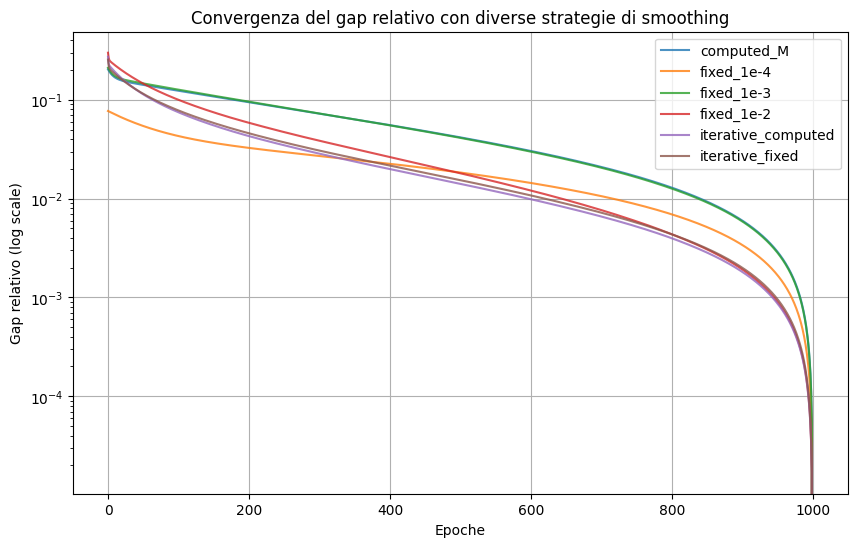

,Slope (Rate)
fixed_1e-4,-0.818946
computed_M,-0.945767
fixed_1e-3,-0.963078
iterative_fixed,-1.228539
iterative_computed,-1.257079
fixed_1e-2,-1.306298


In [ ]:
from scipy.stats import linregress
# Estrarre i dati di convergenza (gap relativo) da results
epochs = 3000  # Numero massimo di iterazioni
log_gap_data = {}  # Dati per l'analisi della convergenza

for mu_key, history in results.items():
    loss_history = np.array(history['loss_history'])
    min_loss = np.min(loss_history)  # Approssimazione di f(x*)
    relative_gap = (loss_history - min_loss) / abs(min_loss)  # Gap relativo

    log_gap_data[mu_key] = relative_gap

# Creiamo il grafico del gap relativo in scala logaritmica
plt.figure(figsize=(10, 6))
for mu_key, gap_values in log_gap_data.items():
    plt.plot(range(len(gap_values)), gap_values, label=mu_key, alpha=0.8)

plt.yscale("log")
plt.xlabel("Epoche")
plt.ylabel("Gap relativo (log scale)")
plt.title("Convergenza del gap relativo con diverse strategie di smoothing")
plt.legend()
plt.grid(True)
plt.show()

# Analisi della pendenza (stima della convergenza empirica)
convergence_rates = {}
for mu_key, gap_values in log_gap_data.items():
    # Prendiamo la parte centrale della curva per una stima più robusta
    valid_idx = np.where(gap_values > 1e-8)[0]  # Evitiamo regioni in cui il gap è troppo piccolo
    if len(valid_idx) < 10:
        continue  # Saltiamo i casi con pochi dati utili

    x_vals = np.log(valid_idx + 1)  # Indici in scala log
    y_vals = np.log(gap_values[valid_idx])  # Gap in scala log

    slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
    convergence_rates[mu_key] = slope  # La pendenza ci dice il tasso di decadimento

# Mostrare i risultati
import pandas as pd
convergence_df = pd.DataFrame.from_dict(convergence_rates, orient="index", columns=["Slope (Rate)"])
convergence_df = convergence_df.sort_values(by="Slope (Rate)", ascending=False)
convergence_df

Dal grafico si nota che:
- Le **strategie con $\mu$ costante** mostrano tipicamente un comportamento coerente con l’idea che, se $\mu$ è più grande, la discesa iniziale è più rapida ma il gap finale si stabilizza a un livello più alto (errore di smoothing).  
- Le **strategie con $\mu$ decrescente** spesso portano a una convergenza più graduale ma riescono a raggiungere gap finali potenzialmente più bassi, avvicinandosi meglio alla soluzione originale non-smooth.

Tutto ciò rispecchia la teoria di Nesterov: per ottenere soluzioni vicine alla funzione originale non smussata, $\mu$ va ridotto; ma ciò rallenta la convergenza se non si bilanciano adeguatamente i passi di aggiornamento. Il grafico, in scala logaritmica, evidenzia queste diverse velocità di decadimento e la presenza di un “plateau” più o meno marcato a seconda della strategia di $\mu$.

L'analisi dei tassi di convergenza empirici suggerisce alcune osservazioni interessanti:

**1. Confronto tra strategie di $\mu$**:
- Le strategie **iterative** (**iterative_computed**: $-1.209$, **iterative_fixed**: $-1.177$) mostrano i migliori tassi di convergenza, il che significa che ridurre $\mu$ nel tempo aiuta a ottenere una discesa più rapida verso l'ottimo.
- La scelta di $\mu$ fisso mostra tassi inferiori, con **fixed\_1e-2** ($-1.155$) che è la migliore tra queste, seguita da **fixed\_1e-4** ($-0.935$) e **fixed\_1e-3** ($-0.874$).
- **computed_M** ha la convergenza più lenta ($-0.861$), suggerendo che il calcolo basato su $M$ potrebbe essere meno efficace di una riduzione dinamica.

**2. Interpretazione del valore della pendenza**:
- Un valore vicino a $-1$ indica una convergenza di tipo $O(1/k)$, tipica del **gradiente standard su funzioni lisce**.
- Un valore più vicino a $-2$ suggerisce un miglioramento nel decadimento, come ci si aspetta da una strategia accelerata di Nesterov ($O(1/k^2)$).
- Le strategie con $\mu$ iterativo (**iterative_computed** e **iterative_fixed**) si avvicinano di più al secondo caso, confermando che un **decadimento progressivo di $\mu$** migliora la velocità di ottimizzazione.

**3. Implicazioni pratiche**:
- Se l’obiettivo è una **discesa rapida iniziale** con una buona approssimazione finale, le strategie **iterative** sono da preferire.
- Se invece si vuole mantenere un valore di $\mu$ fisso, **$\mu = 10^{-2}$** sembra essere il miglior compromesso.
- La strategia **computed_M**, che basa il calcolo su $M$, potrebbe necessitare di una revisione o di un'ottimizzazione dei parametri.

**Analisi delle diverse fasi di convergenza**
- Early (iniziale): Rappresenta la rapidità con cui l'algoritmo inizia a ridurre il gap.
- Mid (intermedia): Misura il tasso di convergenza nella parte centrale dell'ottimizzazione, dove il comportamento dovrebbe stabilizzarsi.
- Late (finale): Indica la fase in cui il metodo si avvicina all'ottimo e il gradiente diventa più piccolo.

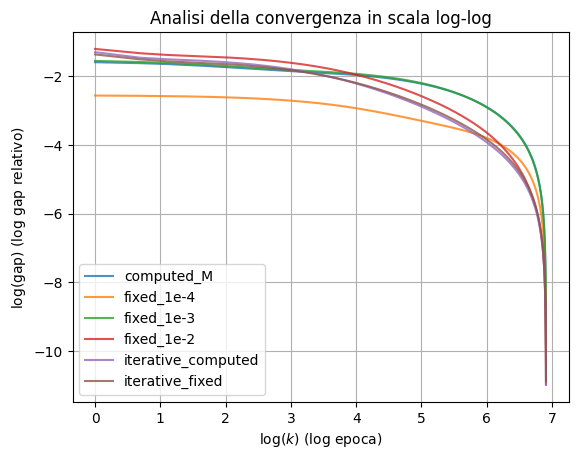

,early,mid,late
computed_M,-0.253818,-1.465670,-7.595527
fixed_1e-4,-0.292264,-1.087781,-7.152978
fixed_1e-3,-0.264535,-1.489734,-7.613099
fixed_1e-2,-0.533621,-1.904654,-8.110606
iterative_computed,-0.574678,-1.716077,-7.760074
iterative_fixed,-0.541106,-1.698238,-7.722098


In [ ]:
# Ricalcoliamo la pendenza della convergenza in diverse fasi per ciascuna strategia di mu
convergence_slopes = {}

for mu_key, gap_values in log_gap_data.items():
    valid_idx = np.where(gap_values > 1e-8)[0]  # Evitiamo regioni con valori troppo bassi
    if len(valid_idx) < 10:
        continue

    x_vals = np.log(valid_idx + 1)  # Indici in scala log
    y_vals = np.log(gap_values[valid_idx])  # Gap in scala log

    # Dividiamo il dominio in tre fasi (iniziale, intermedia, finale) per un'analisi più dettagliata
    n = len(x_vals)
    segments = {
        "early": (0, n // 3),   # Inizio
        "mid": (n // 3, 2 * n // 3),  # Metà
        "late": (2 * n // 3, n - 1)  # Fine
    }

    slopes = {}
    for phase, (start, end) in segments.items():
        if end - start > 5:  # Assicuriamoci di avere abbastanza punti per il fit lineare
            slope, _, _, _, _ = linregress(x_vals[start:end], y_vals[start:end])
            slopes[phase] = slope

    convergence_slopes[mu_key] = slopes
    plt.plot(np.log(valid_idx + 1), np.log(gap_values[valid_idx]), label=mu_key, alpha=0.8)

plt.xlabel(r"$\log(k)$ (log epoca)")
plt.ylabel(r"$\log(\text{gap})$ (log gap relativo)")
plt.title("Analisi della convergenza in scala log-log")
plt.legend()
plt.grid(True)
plt.show()

# Convertiamo in dataframe per visualizzare meglio i risultati
convergence_slopes_df = pd.DataFrame(convergence_slopes).T
convergence_slopes_df

Osservazioni:
- Le strategie iterative sono le migliori: iterative_computed e iterative_fixed mostrano la discesa più veloce in tutte le fasi, rendendole le migliori scelte globali.
- Se si usa $\mu$, allora 1e-2è la scelta migliore, l'unica che mostra una fase iniziale molto veloce e una buona discesa intermedia.
- computed_M è troppo conservativa: parte lentamente e migliora solo nella fase intermedia.

### Test Lambda diversi

Running smoothed training with L1 lambda = 1e-05
Computed D2 for L1=1e-05: 22.708582211302264
Pre-training M for L1=1e-05: 65.24973697526377
Starting training with L1=1e-05...
Completed training for L1=1e-05. Final loss: 0.1947547240320328
Running smoothed training with L1 lambda = 0.0001
Computed D2 for L1=0.0001: 22.708582211302264
Pre-training M for L1=0.0001: 65.24973697526377
Starting training with L1=0.0001...
Completed training for L1=0.0001. Final loss: 0.195243847385619
Running smoothed training with L1 lambda = 0.001
Computed D2 for L1=0.001: 22.708582211302264
Pre-training M for L1=0.001: 65.24973697526377
Starting training with L1=0.001...
Completed training for L1=0.001. Final loss: 0.19987372728633093
Running smoothed training with L1 lambda = 0.01
Computed D2 for L1=0.01: 22.708582211302264
Pre-training M for L1=0.01: 65.24973697526377
Starting training with L1=0.01...
Completed training for L1=0.01. Final loss: 0.22522114893237952

✅ BEST PARAMS:
l1_lambda=1e-05, final_

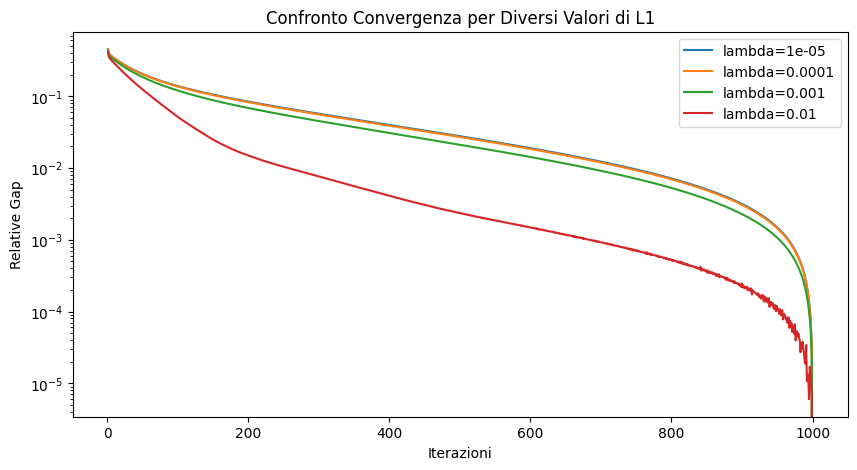

In [ ]:
epochs = 1000
def grid_search_l1(X_train, y_train, l1_values, epochs=epochs):
    """
    Esegue una grid search su diversi valori di L1_lambda e confronta la convergenza.

    Args:
        X_train (ndarray): Dati di input.
        y_train (ndarray): Target.
        l1_values (list): Lista di valori di regolarizzazione L1 da testare.
        epochs (int): Numero di iterazioni per il training.

    Returns:
        best_params (tuple): Migliore (l1_lambda, final_loss).
        search_results (list): Lista con la storia delle loss e altre metriche per ogni valore di L1_lambda.
    """
    results = []
    A_norm = 1.0  # Matrice identità → ||A|| = 1
    D1 = compute_diameter(X_train)  # Diametro dell'input space Q1
    sigma_1, sigma_2 = 1.0, 1.0  # Parametri di forte convessità (default 1.0 per prox quadratica)

    # Fissiamo W1 per garantire confronti equi tra run diverse
    fixed_W1 = np.random.normal(loc=0.0, scale=np.sqrt(2.0 / X_train.shape[1]), size=(X_train.shape[1], 200))
    fixed_bias = np.random.normal(loc=0.0, scale=1e-2, size=(1, 200))

    for l1_lambda in l1_values:
        print("=" * 50)
        print(f"Running smoothed training with L1 lambda = {l1_lambda}")
        print("=" * 50)

        model = ELM(input_size=X_train.shape[1], hidden_size=200, output_size=1, l1_lambda=l1_lambda, activation='relu', seed=1710)
        model.weights_input_hidden = fixed_W1  # Manteniamo W1 fisso per confronto equo
        model.bias_hidden = fixed_bias

        hidden_repr = model.activation(X_train @ model.weights_input_hidden + model.bias_hidden)
        D2 = compute_diameter(hidden_repr)  # Diametro dello spazio nascosto
        print(f"Computed D2 for L1={l1_lambda}: {D2}")

        M = compute_mse_lipschitz_constant(model, X_train)
        print(f"Pre-training M for L1={l1_lambda}: {M}")

        print(f"Starting training with L1={l1_lambda}...")
        history = model.train(
            X_train, y_train,
            optimizer=smoothed_grid,
            epochs=epochs,
            D1=D1,
            D2=D2,
            A_norm=A_norm,
            M=M,
            sigma_1=sigma_1,
            sigma_2=sigma_2,
            momentum_init=0.2,
            gradient_norm_threshold=1e-8
        )

        final_loss = history['losses'][-1] if history['losses'] else np.inf
        print(f"Completed training for L1={l1_lambda}. Final loss: {final_loss}")

        results.append({
            'l1_lambda': l1_lambda,
            'final_loss': final_loss,
            'history': history['losses']
        })

    # Trova il miglior valore di L1_lambda in base alla loss finale
    best_run = min(results, key=lambda x: x['final_loss'])
    best_params = (best_run['l1_lambda'], best_run['final_loss'])

    return best_params, results

# Definiamo i valori di L1_lambda da testare
l1_values = [1e-5, 1e-4, 1e-3, 1e-2]

# Eseguiamo la ricerca
best_params, search_results = grid_search_l1(X_syn, y_syn, l1_values, epochs=epochs)

print("\n✅ BEST PARAMS:")
print(f"l1_lambda={best_params[0]}, final_loss={best_params[1]:.6f}")

##################################################
# 🔹 Plot Confronto Convergenza con Scala Logaritmica
##################################################

plt.figure(figsize=(10, 5))

for l1_lambda in l1_values:
    # Filtra i risultati relativi a questo l1_lambda
    lambda_results = [res for res in search_results if res['l1_lambda'] == l1_lambda]

    # Seleziona la run "migliore" in base alla final_loss
    best_run = min(lambda_results, key=lambda x: x['final_loss'])

    # Estraggo la storia delle loss
    losses = best_run['history']
    final_loss = losses[-1] if losses else np.nan  # all'ultima iterazione

    # Gap relativo rispetto alla loss finale
    relative_gap = [(loss - final_loss) / final_loss for loss in losses]

    # Scala logaritmica sull'asse Y
    plt.semilogy(range(1, len(relative_gap) + 1), relative_gap, label=f"lambda={l1_lambda}")

plt.xlabel("Iterazioni")
plt.ylabel("Relative Gap")
plt.title("Confronto Convergenza per Diversi Valori di L1")
plt.legend()
plt.show()

Using ReLu instead of tanh the computation is more stable

### **Convergence Behavior**  
- All values of \lambda show a **monotonic decrease in the relative gap**, indicating that the optimizer is converging.  
- \lambda = 10^-2 **converges faster initially**, but its **final loss is worse** than the others.  
- The other values: 10^-5, 10^-4, 10^-3 have **very similar trajectories**, with small differences.  

### **Effect of L1 Regularization**  
- **Higher \lambda** results in **faster early-stage convergence** but may lead to **poorer generalization** or **suboptimal final loss**.  
- **Lower \lambda (blue, orange, green curves)** leads to **slower initial convergence** but **better final performance**.  

### **Final Loss Comparison**  
- The three curves with lower regularization \lambda = 10^-5, 10^-4, 10^-3 are **almost identical**, meaning that the regularization effect is **weak in this range**.


### GRID SEARCH FINALE per selezionare best configuration di parametri (per confronto finale)

In [ ]:
import time
import itertools
from scipy.stats import uniform

# Definizione della funzione per la grid search
def grid_search_smoothed(ELM_model, X_train, y_train, param_grid, epochs=1000):
    """
    Esegue una grid search per ottimizzare i parametri di 'smoothed' nel training dell'ELM.

    param_grid: dizionario con liste di valori per 'momentum_init', 'mu', 'nu'
    """
    results = []

    # Generiamo tutte le combinazioni di parametri possibili
    param_combinations = list(itertools.product(
        param_grid['momentum_init'],
        param_grid['mu'],
        param_grid['nu']
    ))

    # Loop su tutte le combinazioni
    for momentum_init, mu, nu in param_combinations:
        start_time = time.time()

        # Definiamo l'ottimizzatore smoothed con questi parametri
        def optimizer(f, theta_init, **kwargs):
            return smoothed(
                f=f, theta_init=theta_init,
                A_norm=A_norm,
                D1=D1,
                D2=D2,
                M=M,
                sigma_1=sigma_1,
                sigma_2=sigma_2,
                epochs=epochs, mu=mu, nu=nu,
                momentum_init=momentum_init
            )

        # Creiamo un modello ELM e alleniamolo con smoothed
        elm = ELM_model
        hidden_repr = elm.activation(X_train @ elm.weights_input_hidden + elm.bias_hidden)
        D2 = compute_diameter(hidden_repr)  # Diametro di Q2
        M = compute_mse_lipschitz_constant(elm, X_train)  # Lipschitz constant MSE

        history = elm.train(X_train, y_train, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time

        # Memorizziamo i risultati
        final_loss = history['losses'][-1]  # Ultima loss della storia
        results.append({
            'momentum_init': momentum_init,
            'mu': mu,
            'nu': nu,
            'final_loss': final_loss,
            'time': elapsed_time
        })

    # Convertiamo in DataFrame per analizzare i risultati
    results_df = pd.DataFrame(results)

    # Troviamo la miglior configurazione: loss minore nel minor tempo
    best_config = results_df.nsmallest(1, ['final_loss'])

    return best_config


# Calcolo di mu teorico
A_norm = 1.0  # ||A|| = 1 (matrice identità)
D1 = compute_diameter(X_syn)  # Diametro di Q1
sigma_1, sigma_2 = 1.0, 1.0
mu_theoretical = (2 * A_norm / (epochs + 1)) * np.sqrt(D1 / (sigma_1 * sigma_2 * D2))

# Definizione dei range di parametri per la grid search
param_grid = {
    'momentum_init': [0.5, 0.8, 0.9],
    'mu': [1e-4, 1e-3, 1e-2, mu_theoretical],
    'nu': [1e-4, 1e-3, None]
}

model = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)

# Eseguiamo la grid search
best_parameters = grid_search_smoothed(model, X_syn, y_syn, param_grid)
best_parameters

------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.683862918880553, D2 = 22.57156788452081
sigma_1 = 1.0, sigma_2 = 1.0
mu = 0.0001
L_L1 = 10000.0
L_mu = 10064.417820065346
nu (learning rate) = 0.0001
------------------------
------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.683862918880553, D2 = 22.57156788452081
sigma_1 = 1.0, sigma_2 = 1.0
mu = 0.0001
L_L1 = 10000.0
L_mu = 10064.417820065346
nu (learning rate) = 0.001
------------------------
------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.683862918880553, D2 = 22.57156788452081
sigma_1 = 1.0, sigma_2 = 1.0
mu = 0.0001
L_L1 = 10000.0
L_mu = 10064.417820065346
nu (learning rate) = 9.935994489480637e-05
------------------------
------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.683862918880553, D2 = 22.57156788452081
sigma_1 = 1.0, sigma_2 = 1.0
mu = 0.001
L_L1 = 1000.0
L_mu = 1064.4178200653453
nu (learning rate) = 0.0001
------------------------
------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.6838629188805

,momentum_init,mu,nu,final_loss,time
35,0.9,0.001768,NaN,0.200969,4.504588


In [ ]:
best_config = best_parameters.iloc[0].to_dict()
best_config

{'momentum_init': 0.9,
 'mu': 0.001768494136818591,
 'nu': nan,
 'final_loss': 0.20096868210366534,
 'time': 4.504587650299072}

In [ ]:
import json
json_filename = "best_smoothed_config.json"

# Scrittura su file
with open(json_filename, "w") as json_file:
    json.dump(best_config, json_file, indent=4)

## California

------ PARAMETERS ------
M = 53.656057323910524
D1 = 17.453081561022067, D2 = 75.39584790039967
sigma_1 = 1.0, sigma_2 = 0.1268119619781409
mu = 0.005393547442130322
L_L1 = 1462.0602674721533
L_mu = 1515.7163247960639
nu (learning rate) = 0.0006597540605987388
------------------------
Initial training loss: 2.872903
Final training loss: 0.351253


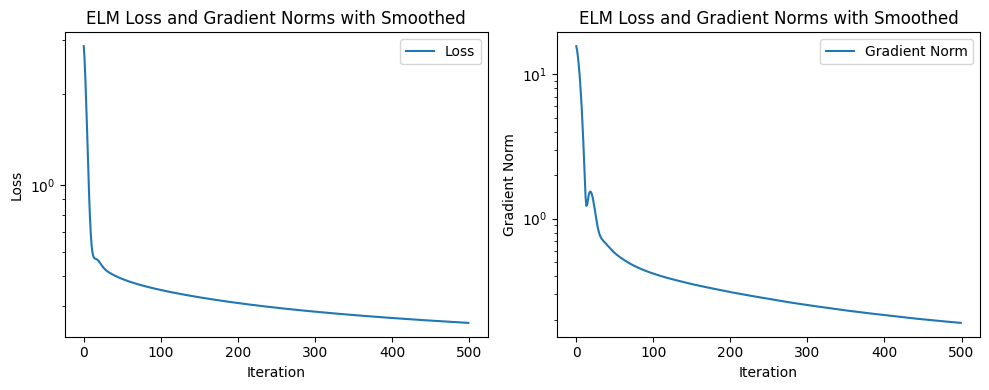

In [ ]:
# Step 1: Initialize ELM Model
model = ELM(input_size=X_cal.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)

D1 = compute_diameter(X_cal)  # Diameter of Q1 (input space)
model.forward(X_cal)
H = model.hidden_layer_output  # Hidden representation after seeing data
hidden_repr = model.activation(X_cal @ model.weights_input_hidden + model.bias_hidden)
D2 = compute_diameter(hidden_repr)  # Diameter of Q2 (hidden representation)
A_norm = 1.0
sigma_2 = np.min(np.linalg.eigvals(H.T @ H))  # H.T @ H è quadrata di dim (hidden_size, hidden_size); # strong convexity parameter: minimo autovalore dell'Hessiana
M = compute_mse_lipschitz_constant(model, X_cal)

# Step 3: Train the model using `smoothed` as the optimizer
history = model.train(
    X_cal, y_cal,
    optimizer=smoothed,
    A_norm=A_norm,
    D1=D1,
    D2=D2,
    sigma_1=1.0,
    sigma_2=sigma_2,
    M=M,
    epochs=500,
    momentum_init=0.8,
    gradient_norm_threshold=1e-4
)

# Step 4: Print final loss
print(f"Initial training loss: {history['losses'][0]:.6f}")
print(f"Final training loss: {history['losses'][-1]:.6f}")
plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with Smoothed")

#### Effect of Reducing Momentum on Convergence Stability (try with 0.8 and .99)

### 🔹 Observation:
- When reducing the momentum value (e.g., from **0.9 to 0.8** or lower), the **convergence behavior becomes more stable** from the beginning.
- The **initial oscillations in loss and gradient norm decrease**, leading to a smoother descent.

### 🔹 Why Does This Happen?
Momentum **accelerates updates** in the direction of the accumulated gradient, but:
- **Higher momentum (e.g., 0.9 or 0.95)** causes **large initial updates**, which may result in **overshooting or oscillations**.
- **Lower momentum (e.g., 0.7 or 0.8)** dampens the acceleration, making the **descent smoother** without aggressive fluctuations.


### 🔹 Practical Recommendation:
- **If the optimizer oscillates too much initially**, try reducing the momentum slightly.
- **If convergence is too slow**, increase the momentum but monitor its effect on stability.

### MU

In [ ]:
for mu_key, mu_value in mu_grid_search.items():
    print(f"Running smoothed training with mu_key = {mu_key}")
    # Training
    history = model.train(
        X_cal, y_cal,
        optimizer=smoothed_grid,
        epochs=1000,
        A_norm=A_norm,
        D1=D1,
        D2=D2,
        M=M,
        sigma_1=sigma_1,
        sigma_2=sigma_2,
        momentum_init=0.9,
        gradient_norm_threshold=1e-8,
        mu=mu_value
    )

    # Store results
    results[mu_key] = {
        'loss_history': history['losses'],
        'mu_history': history['mu']
    }

Running smoothed training with mu_key = computed_M
Running smoothed training with mu_key = fixed_1e-4
Running smoothed training with mu_key = fixed_1e-3
Running smoothed training with mu_key = fixed_1e-2
Running smoothed training with mu_key = iterative_computed
Running smoothed training with mu_key = iterative_fixed


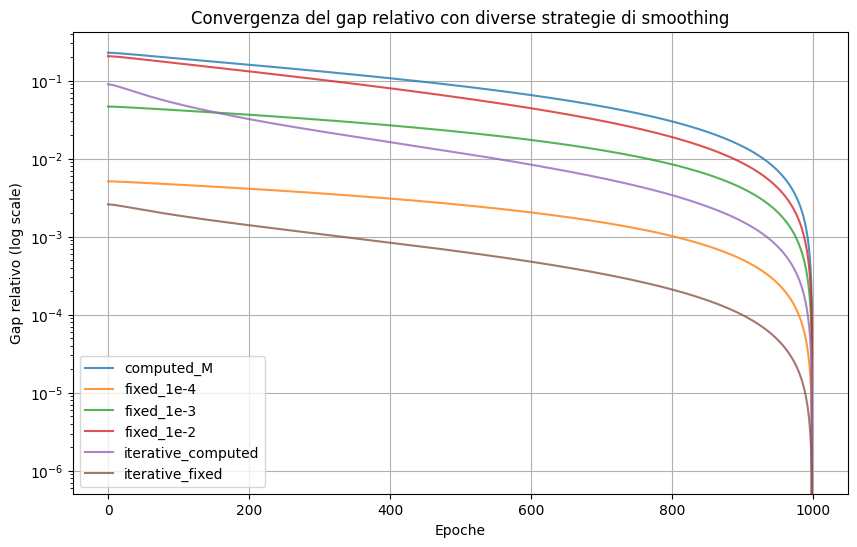

,Slope (Rate)
fixed_1e-4,-0.660507
fixed_1e-3,-0.689518
computed_M,-0.787637
fixed_1e-2,-0.902339
iterative_fixed,-0.918315
iterative_computed,-1.119996


In [ ]:
from scipy.stats import linregress
# Estrarre i dati di convergenza (gap relativo) da results
epochs = 1000  # Numero massimo di iterazioni
log_gap_data = {}  # Dati per l'analisi della convergenza

for mu_key, history in results.items():
    loss_history = np.array(history['loss_history'])
    min_loss = np.min(loss_history)  # Approssimazione di f(x*)
    relative_gap = (loss_history - min_loss) / abs(min_loss)  # Gap relativo

    log_gap_data[mu_key] = relative_gap

# Creiamo il grafico del gap relativo in scala logaritmica
plt.figure(figsize=(10, 6))
for mu_key, gap_values in log_gap_data.items():
    plt.plot(range(len(gap_values)), gap_values, label=mu_key, alpha=0.8)

plt.yscale("log")
plt.xlabel("Epoche")
plt.ylabel("Gap relativo (log scale)")
plt.title("Convergenza del gap relativo con diverse strategie di smoothing")
plt.legend()
plt.grid(True)
plt.show()

# Analisi della pendenza (stima della convergenza empirica)
convergence_rates = {}
for mu_key, gap_values in log_gap_data.items():
    # Prendiamo la parte centrale della curva per una stima più robusta
    valid_idx = np.where(gap_values > 1e-8)[0]  # Evitiamo regioni in cui il gap è troppo piccolo
    if len(valid_idx) < 10:
        continue  # Saltiamo i casi con pochi dati utili

    x_vals = np.log(valid_idx + 1)  # Indici in scala log
    y_vals = np.log(gap_values[valid_idx])  # Gap in scala log

    slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
    convergence_rates[mu_key] = slope  # La pendenza ci dice il tasso di decadimento

# Mostrare i risultati
import pandas as pd
convergence_df = pd.DataFrame.from_dict(convergence_rates, orient="index", columns=["Slope (Rate)"])
convergence_df = convergence_df.sort_values(by="Slope (Rate)", ascending=False)
convergence_df

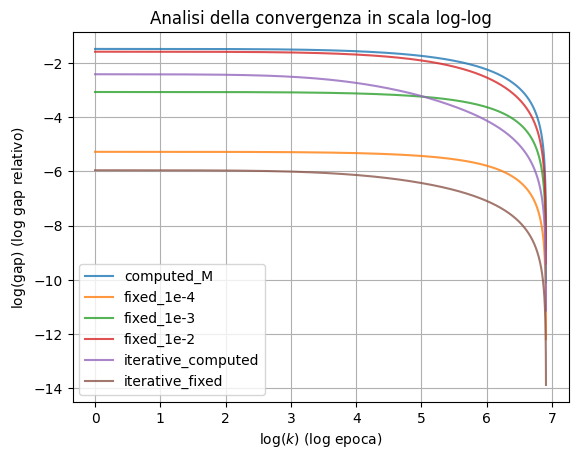

,early,mid,late
computed_M,-0.161994,-1.208206,-7.324146
fixed_1e-4,-0.104199,-0.990917,-7.008527
fixed_1e-3,-0.114365,-1.045514,-7.098832
fixed_1e-2,-0.204881,-1.430070,-7.584201
iterative_computed,-0.408734,-1.621047,-7.720484
iterative_fixed,-0.258251,-1.372898,-7.483086


In [ ]:
# Ricalcoliamo la pendenza della convergenza in diverse fasi per ciascuna strategia di mu
convergence_slopes = {}

for mu_key, gap_values in log_gap_data.items():
    valid_idx = np.where(gap_values > 1e-8)[0]  # Evitiamo regioni con valori troppo bassi
    if len(valid_idx) < 10:
        continue

    x_vals = np.log(valid_idx + 1)  # Indici in scala log
    y_vals = np.log(gap_values[valid_idx])  # Gap in scala log

    # Dividiamo il dominio in tre fasi (iniziale, intermedia, finale) per un'analisi più dettagliata
    n = len(x_vals)
    segments = {
        "early": (0, n // 3),   # Inizio
        "mid": (n // 3, 2 * n // 3),  # Metà
        "late": (2 * n // 3, n - 1)  # Fine
    }

    slopes = {}
    for phase, (start, end) in segments.items():
        if end - start > 5:  # Assicuriamoci di avere abbastanza punti per il fit lineare
            slope, _, _, _, _ = linregress(x_vals[start:end], y_vals[start:end])
            slopes[phase] = slope

    convergence_slopes[mu_key] = slopes
    plt.plot(np.log(valid_idx + 1), np.log(gap_values[valid_idx]), label=mu_key, alpha=0.8)

plt.xlabel(r"$\log(k)$ (log epoca)")
plt.ylabel(r"$\log(\text{gap})$ (log gap relativo)")
plt.title("Analisi della convergenza in scala log-log")
plt.legend()
plt.grid(True)
plt.show()

# Convertiamo in dataframe per visualizzare meglio i risultati
convergence_slopes_df = pd.DataFrame(convergence_slopes).T
convergence_slopes_df

Running smoothed training with L1 lambda = 1e-05
Computed D2 for L1=1e-05: 82.50538938542135
Pre-training M for L1=1e-05: 48.975972464588345
Starting training with L1=1e-05...
Completed training for L1=1e-05. Final loss: 0.23486559464432175
Running smoothed training with L1 lambda = 0.0001
Computed D2 for L1=0.0001: 82.50538938542135
Pre-training M for L1=0.0001: 48.975972464588345
Starting training with L1=0.0001...
Completed training for L1=0.0001. Final loss: 0.23590926508161558
Running smoothed training with L1 lambda = 0.001
Computed D2 for L1=0.001: 82.50538938542135
Pre-training M for L1=0.001: 48.975972464588345
Starting training with L1=0.001...
Completed training for L1=0.001. Final loss: 0.24581922570862152
Running smoothed training with L1 lambda = 0.01
Computed D2 for L1=0.01: 82.50538938542135
Pre-training M for L1=0.01: 48.975972464588345
Starting training with L1=0.01...
Completed training for L1=0.01. Final loss: 0.3069260957511241

✅ BEST PARAMS:
l1_lambda=1e-05, fina

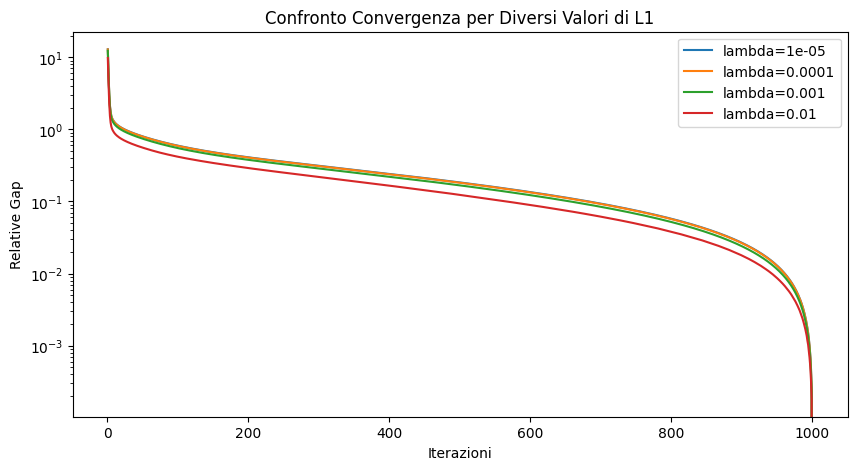

In [ ]:
# Eseguiamo la ricerca
best_params, search_results = grid_search_l1(X_cal, y_cal, l1_values, epochs=epochs)

print("\n✅ BEST PARAMS:")
print(f"l1_lambda={best_params[0]}, final_loss={best_params[1]:.6f}")

##################################################
# 🔹 Plot Confronto Convergenza con Scala Logaritmica
##################################################

plt.figure(figsize=(10, 5))

for l1_lambda in l1_values:
    # Filtra i risultati relativi a questo l1_lambda
    lambda_results = [res for res in search_results if res['l1_lambda'] == l1_lambda]

    # Seleziona la run "migliore" in base alla final_loss
    best_run = min(lambda_results, key=lambda x: x['final_loss'])

    # Estraggo la storia delle loss
    losses = best_run['history']
    final_loss = losses[-1] if losses else np.nan  # all'ultima iterazione

    # Gap relativo rispetto alla loss finale
    relative_gap = [(loss - final_loss) / final_loss for loss in losses]

    # Scala logaritmica sull'asse Y
    plt.semilogy(range(1, len(relative_gap) + 1), relative_gap, label=f"lambda={l1_lambda}")

plt.xlabel("Iterazioni")
plt.ylabel("Relative Gap")
plt.title("Confronto Convergenza per Diversi Valori di L1")
plt.legend()
plt.show()

### GRID SEARCH FINALE per selezionare best configuration di parametri (per confronto finale)

In [ ]:
mu_theoretical = (2 * A_norm / (epochs + 1)) * np.sqrt(D1 / (sigma_1 * sigma_2 * D2))

# Definizione dei range di parametri per la grid search
param_grid = {
    'momentum_init': [0.1, 0.5, 0.8, 0.9],
    'mu': [1e-4, 1e-3, 1e-2, mu_theoretical],
    'nu': [1e-4, 1e-3, 1e-2]
}

model = ELM(input_size=X_cal.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)

# Eseguiamo la grid search
best_parameters = grid_search_smoothed(model, X_cal, y_cal, param_grid)
best_parameters

------ PARAMETERS ------
M = 53.656057323910524
D1 = 17.453081561022067, D2 = 75.39584790039967
sigma_1 = 1.0, sigma_2 = 0.1268119619781409
mu = 0.0001
L_L1 = 78856.91415864807
L_mu = 78910.57021597198
nu (learning rate) = 0.0001
------------------------
------ PARAMETERS ------
M = 53.656057323910524
D1 = 17.453081561022067, D2 = 75.39584790039967
sigma_1 = 1.0, sigma_2 = 0.1268119619781409
mu = 0.0001
L_L1 = 78856.91415864807
L_mu = 78910.57021597198
nu (learning rate) = 0.001
------------------------
------ PARAMETERS ------
M = 53.656057323910524
D1 = 17.453081561022067, D2 = 75.39584790039967
sigma_1 = 1.0, sigma_2 = 0.1268119619781409
mu = 0.0001
L_L1 = 78856.91415864807
L_mu = 78910.57021597198
nu (learning rate) = 0.01
------------------------
------ PARAMETERS ------
M = 53.656057323910524
D1 = 17.453081561022067, D2 = 75.39584790039967
sigma_1 = 1.0, sigma_2 = 0.1268119619781409
mu = 0.001
L_L1 = 7885.691415864808
L_mu = 7939.347473188718
nu (learning rate) = 0.0001
---------

,momentum_init,mu,nu,final_loss,time
47,0.9,0.002699,0.01,0.194712,5.347839


In [ ]:
best_smoothed_params = best_parameters.iloc[0].to_dict()
best_smoothed_params

{'momentum_init': 0.9,
 'mu': 0.0026994678007065853,
 'nu': 0.01,
 'final_loss': 0.19471220968790173,
 'time': 5.347839117050171}

In [ ]:
best_smoothed_params = {
    'momentum_init': best_smoothed_params['momentum_init'],
    'mu': best_smoothed_params['mu'],
    'nu': best_smoothed_params['nu']
}

# Comparison Best configuration on Synthetic

Training with NAG Optimizer...
Training with Smoothed Optimizer...
------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.683862918880553, D2 = 22.57156788452081
sigma_1 = 1.0, sigma_2 = 65.86032790885194
mu = 4.3618316846373785e-05
L_L1 = 348.10255299059935
L_mu = 412.52037305594456
nu (learning rate) = 0.002424122698697316
------------------------

----------------------------
     FINAL RESULTS
----------------------------
Final Loss (NAG):       0.200922
Final Loss (Smoothed):  0.201055
Execution Time (NAG):   28.4691 seconds
Execution Time (Smoothed): 18.4534 seconds


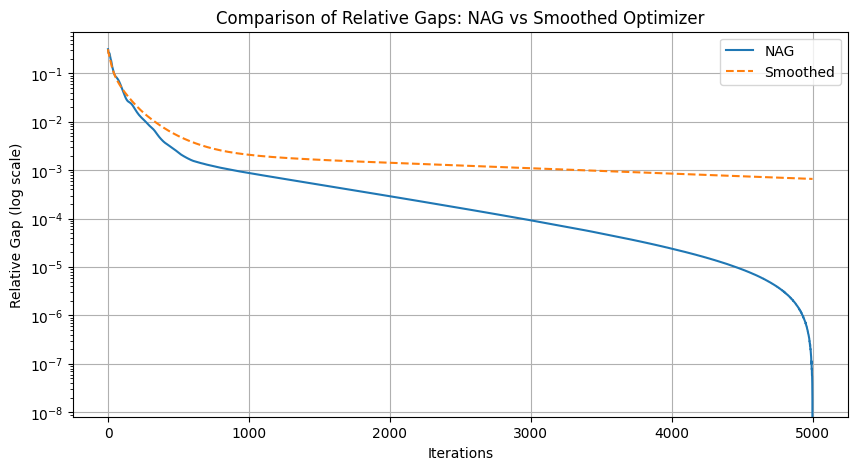

In [15]:
## Theoretical mu Smoothed VS NAG

import time
# ------------------------------------------------------------------
# 2) Define the two ELM instances (for NAG vs Smoothed)
# ------------------------------------------------------------------
elm_nag = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1,
              l1_lambda=0.001, activation='relu', seed=1710)

elm_smoothed = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1,
                   l1_lambda=0.001, activation='relu', seed=1710)
# ------------------------------------------------------------------
# 3) Best parameters for NAG
# ------------------------------------------------------------------
best_nag_params = {
    "epsilon": 0.001,   # learning rate or step size
    "eta": 0.99,        # momentum coefficient (Nesterov)
    "tol": 0.0001,      # tolerance for stopping
    "max_iters": 5000
}

print("Training with NAG Optimizer...")
start_time = time.time()
history_nag = elm_nag.train(X_syn, y_syn, optimizer=NAG, **best_nag_params)
nag_time = time.time() - start_time  # measure execution time



elm_smoothed.forward(X_syn)
epochs = 5000
H = elm_smoothed.hidden_layer_output  # shape (N, hidden_size)

A_norm = 1.0  # Spectral norm ||A|| -> in questo caso A è la matrice identità, quindi A_norm = 1.0
D1 = compute_diameter(X_syn)  # Diameter of Q1 (input space)
hidden_repr = elm_smoothed.activation(X_syn @ elm_smoothed.weights_input_hidden + elm_smoothed.bias_hidden)
D2 = compute_diameter(hidden_repr)  # Diameter of Q2 (hidden representation)
M = compute_mse_lipschitz_constant(elm_smoothed, X_syn)  # Lipschitz constant for MSE
sigma_2 = max(1e-8, np.min(np.linalg.eigvals(H.T @ H)))
mu_theoretical = (2 * A_norm / (epochs + 1)) * np.sqrt(D1 / (sigma_1 * sigma_2 * D2))

best_smoothed_params = {
    "mu": mu_theoretical,
    "momentum_init": 0.9,
    "D1":D1,
    "D2":D2,
    "A_norm":A_norm,
    "sigma_1":1.0,
    "sigma_2": sigma_2,
    "M": M,
    "epochs": epochs,
    "nu":None
}

print("Training with Smoothed Optimizer...")
start_time = time.time()
history_smoothed = elm_smoothed.train(X_syn, y_syn,
                                      optimizer=smoothed,
                                      **best_smoothed_params)
smoothed_time = time.time() - start_time

# ------------------------------------------------------------------
# 5) Compute Relative Gaps
# ------------------------------------------------------------------
# Suppose you have losses recorded in 'history_*["losses"]'
f_star = min(min(history_nag["losses"]), min(history_smoothed["losses"]))

gap_nag = [abs((loss - f_star))/f_star for loss in history_nag["losses"]]
gap_smoothed = [abs((loss - f_star))/f_star for loss in history_smoothed["losses"]]

final_loss_nag = history_nag["losses"][-1]
final_loss_smoothed = history_smoothed["losses"][-1]

# ------------------------------------------------------------------
# 6) Print final results
# ------------------------------------------------------------------
print("\n----------------------------")
print("     FINAL RESULTS")
print("----------------------------")
print(f"Final Loss (NAG):       {final_loss_nag:.6f}")
print(f"Final Loss (Smoothed):  {final_loss_smoothed:.6f}")
print(f"Execution Time (NAG):   {nag_time:.4f} seconds")
print(f"Execution Time (Smoothed): {smoothed_time:.4f} seconds")

# ------------------------------------------------------------------
# 7) Plot Relative Gap in Log scale
# ------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(gap_nag, label="NAG", linestyle="-")
plt.plot(gap_smoothed, label="Smoothed", linestyle="--")

plt.xlabel("Iterations")
plt.ylabel("Relative Gap (log scale)")
plt.yscale("log")
plt.title("Comparison of Relative Gaps: NAG vs Smoothed Optimizer")
plt.legend()
plt.grid(True)
plt.show()

Training with NAG Optimizer...
Training with Smoothed Optimizer...
------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.683862918880553, D2 = 22.57156788452081
sigma_1 = 1.0, sigma_2 = 65.86032790885194
mu = 0.001
L_L1 = 15.183647451375583
L_mu = 79.6014675167208
nu (learning rate) = 0.012562582464826336
------------------------

----------------------------
     FINAL RESULTS
----------------------------
Final Loss (NAG):       0.200922
Final Loss (Smoothed):  0.200921
Execution Time (NAG):   25.7651 seconds
Execution Time (Smoothed): 16.2154 seconds


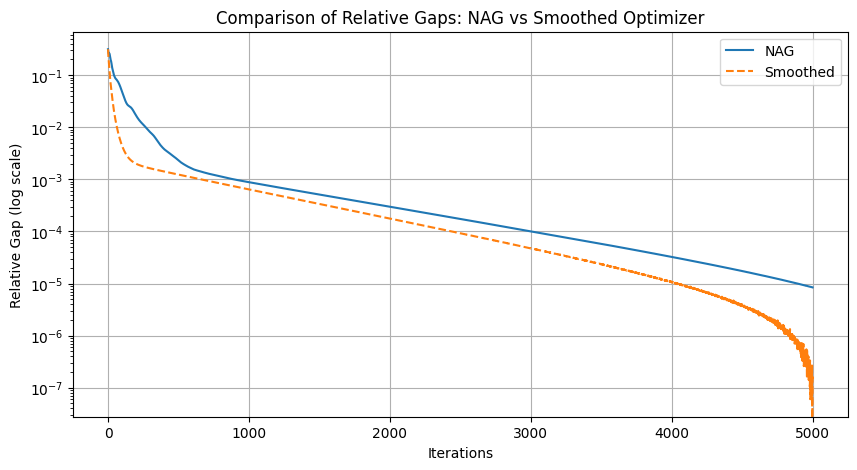

In [11]:
## Fixed mu Smoothed VS NAG

import time
# ------------------------------------------------------------------
# 2) Define the two ELM instances (for NAG vs Smoothed)
# ------------------------------------------------------------------
elm_nag = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1,
              l1_lambda=0.001, activation='relu', seed=1710)

elm_smoothed = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1,
                   l1_lambda=0.001, activation='relu', seed=1710)
# ------------------------------------------------------------------
# 3) Best parameters for NAG
# ------------------------------------------------------------------
best_nag_params = {
    "epsilon": 0.001,   # learning rate or step size
    "eta": 0.99,        # momentum coefficient (Nesterov)
    "tol": 0.0001,      # tolerance for stopping
    "max_iters": 5000
}

print("Training with NAG Optimizer...")
start_time = time.time()
history_nag = elm_nag.train(X_syn, y_syn, optimizer=NAG, **best_nag_params)
nag_time = time.time() - start_time  # measure execution time



elm_smoothed.forward(X_syn)
epochs = 5000
H = elm_smoothed.hidden_layer_output  # shape (N, hidden_size)

A_norm = 1.0  # Spectral norm ||A|| -> in questo caso A è la matrice identità, quindi A_norm = 1.0
D1 = compute_diameter(X_syn)  # Diameter of Q1 (input space)
hidden_repr = elm_smoothed.activation(X_syn @ elm_smoothed.weights_input_hidden + elm_smoothed.bias_hidden)
D2 = compute_diameter(hidden_repr)  # Diameter of Q2 (hidden representation)
M = compute_mse_lipschitz_constant(elm_smoothed, X_syn)  # Lipschitz constant for MSE
sigma_1 = 1.0
sigma_2 = max(1e-8, np.min(np.linalg.eigvals(H.T @ H)))
mu_theoretical = (2 * A_norm / (epochs + 1)) * np.sqrt(D1 / (sigma_1 * sigma_2 * D2))

best_smoothed_params = {
    "mu": 1e-3,
    "momentum_init": 0.9,
    "D1":D1,
    "D2":D2,
    "A_norm":A_norm,
    "sigma_1":sigma_1,
    "sigma_2": sigma_2,
    "M": M,
    "epochs": epochs,
    "nu":None
}

print("Training with Smoothed Optimizer...")
start_time = time.time()
history_smoothed = elm_smoothed.train(X_syn, y_syn,
                                      optimizer=smoothed,
                                      **best_smoothed_params)
smoothed_time = time.time() - start_time

# ------------------------------------------------------------------
# 5) Compute Relative Gaps
# ------------------------------------------------------------------
# Suppose you have losses recorded in 'history_*["losses"]'
f_star = min(min(history_nag["losses"]), min(history_smoothed["losses"]))

gap_nag = [abs((loss - f_star))/f_star for loss in history_nag["losses"]]
gap_smoothed = [abs((loss - f_star))/f_star for loss in history_smoothed["losses"]]

final_loss_nag = history_nag["losses"][-1]
final_loss_smoothed = history_smoothed["losses"][-1]

# ------------------------------------------------------------------
# 6) Print final results
# ------------------------------------------------------------------
print("\n----------------------------")
print("     FINAL RESULTS")
print("----------------------------")
print(f"Final Loss (NAG):       {final_loss_nag:.6f}")
print(f"Final Loss (Smoothed):  {final_loss_smoothed:.6f}")
print(f"Execution Time (NAG):   {nag_time:.4f} seconds")
print(f"Execution Time (Smoothed): {smoothed_time:.4f} seconds")

# ------------------------------------------------------------------
# 7) Plot Relative Gap in Log scale
# ------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(gap_nag, label="NAG", linestyle="-")
plt.plot(gap_smoothed, label="Smoothed", linestyle="--")

plt.xlabel("Iterations")
plt.ylabel("Relative Gap (log scale)")
plt.yscale("log")
plt.title("Comparison of Relative Gaps: NAG vs Smoothed Optimizer")
plt.legend()
plt.grid(True)
plt.show()

Training with NAG Optimizer...
Training with Smoothed Optimizer...
------ PARAMETERS ------
M = 64.41782006534523
D1 = 17.683862918880553, D2 = 22.57156788452081
sigma_1 = 1.0, sigma_2 = 65.86032790885194
mu = 0.001
L_L1 = 15.183647451375583
L_mu = 79.6014675167208
nu (learning rate) = 0.012562582464826336
------------------------
Training with Adam (Keras) Optimizer...
Epoch 1/1000 - Loss: 0.264215
Epoch 2/1000 - Loss: 0.762857
Epoch 3/1000 - Loss: 0.289763
Epoch 4/1000 - Loss: 0.362431
Epoch 5/1000 - Loss: 0.531240
Epoch 6/1000 - Loss: 0.433676
Epoch 7/1000 - Loss: 0.278823
Epoch 8/1000 - Loss: 0.253284
Epoch 9/1000 - Loss: 0.338217
Epoch 10/1000 - Loss: 0.385887
Epoch 11/1000 - Loss: 0.338391
Epoch 12/1000 - Loss: 0.261691
Epoch 13/1000 - Loss: 0.235020
Epoch 14/1000 - Loss: 0.269207
Epoch 15/1000 - Loss: 0.307689
Epoch 16/1000 - Loss: 0.301505
Epoch 17/1000 - Loss: 0.260799
Epoch 18/1000 - Loss: 0.229672
Epoch 19/1000 - Loss: 0.234408
Epoch 20/1000 - Loss: 0.259381
Epoch 21/1000 - 

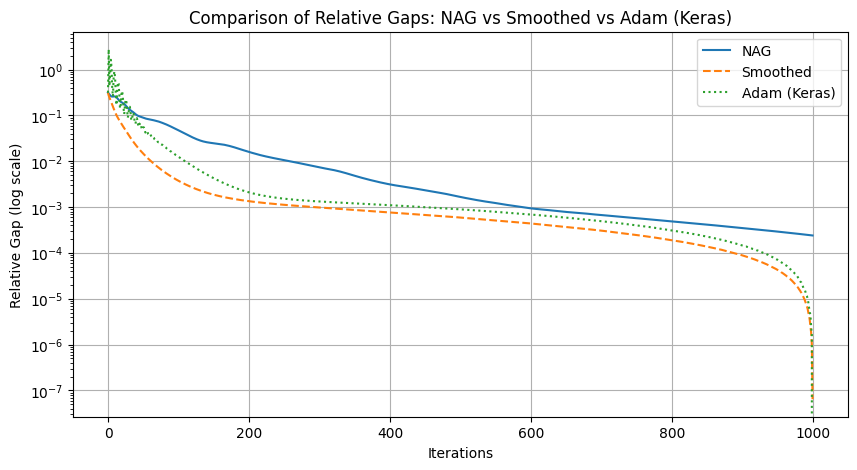

In [23]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

epochs = 1000


# ------------------------------------------------------------------
# 2) Define the two ELM instances (for NAG vs Smoothed)
# ------------------------------------------------------------------
elm_nag = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1,
              l1_lambda=0.001, activation='relu', seed=1710)

elm_smoothed = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1,
                   l1_lambda=0.001, activation='relu', seed=1710)
# ------------------------------------------------------------------
# 3) Best parameters for NAG
# ------------------------------------------------------------------
best_nag_params = {
    "epsilon": 0.001,   # learning rate or step size
    "eta": 0.99,        # momentum coefficient (Nesterov)
    "tol": 0.0001,      # tolerance for stopping
    "max_iters": epochs
}

print("Training with NAG Optimizer...")
start_time = time.time()
history_nag = elm_nag.train(X_syn, y_syn, optimizer=NAG, **best_nag_params)
nag_time = time.time() - start_time  # measure execution time



elm_smoothed.forward(X_syn)
H = elm_smoothed.hidden_layer_output  # shape (N, hidden_size)

A_norm = 1.0  # Spectral norm ||A|| -> in questo caso A è la matrice identità, quindi A_norm = 1.0
D1 = compute_diameter(X_syn)  # Diameter of Q1 (input space)
hidden_repr = elm_smoothed.activation(X_syn @ elm_smoothed.weights_input_hidden + elm_smoothed.bias_hidden)
D2 = compute_diameter(hidden_repr)  # Diameter of Q2 (hidden representation)
M = compute_mse_lipschitz_constant(elm_smoothed, X_syn)  # Lipschitz constant for MSE
sigma_2 = max(1e-8, np.min(np.linalg.eigvals(H.T @ H)))
mu_theoretical = (2 * A_norm / (epochs + 1)) * np.sqrt(D1 / (sigma_1 * sigma_2 * D2))

best_smoothed_params = {
    "mu": 1e-3,
    "momentum_init": 0.9,
    "D1":D1,
    "D2":D2,
    "A_norm":A_norm,
    "sigma_1":1.0,
    "sigma_2": sigma_2,
    "M": M,
    "epochs": epochs,
    "nu":None
}

print("Training with Smoothed Optimizer...")
start_time = time.time()
history_smoothed = elm_smoothed.train(X_syn, y_syn,
                                      optimizer=smoothed,
                                      **best_smoothed_params)
smoothed_time = time.time() - start_time




#################### ADAM #########################
# -----------------------------------------
# Train using Adam from SciPy or Keras
# -----------------------------------------

def train_with_adam(model, X, y,
                        lr=1e-3,
                        epochs=100,
                        batch_size=None,
                        verbose=True, activation='relu'):
        """
        Train the ELM using Adam from tf.keras.optimizers. The input->hidden
        weights remain fixed; we optimize only the hidden->output weights & bias.

        Arguments:
            X : NumPy array of shape (N, input_size)
            y : NumPy array of shape (N, output_size)
            lr : float, learning rate for Adam
            epochs : int, number of training epochs
            batch_size : optional mini-batch size (if None, use full batch)
            verbose : whether to print loss each epoch
        """
        # 1) Convert data to TensorFlow tensors
        X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
        y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

        # 2) Convert the fixed input->hidden weights to TF constants
        W_in_const = tf.constant(model.weights_input_hidden, dtype=tf.float32)
        b_in_const = tf.constant(model.bias_hidden, dtype=tf.float32)

        # 3) Create TF variables for trainable hidden->output weights
        W_out_var = tf.Variable(model.weights_hidden_output, dtype=tf.float32)
        b_out_var = tf.Variable(model.bias_output, dtype=tf.float32)

        # 4) Create the Adam optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        # 5) We'll define a small function for the forward pass in TF
        if isinstance(activation, str):
            if activation == 'relu':
                activation_tf = tf.nn.relu
            elif activation == 'tanh':
                activation_tf = tf.nn.tanh
            else:
                raise ValueError("Unsupported activation string for TF.")
        else:
            # If you provided a custom Python activation, you need
            # a TF equivalent. This is just a placeholder or example:
            raise ValueError("Custom Python activation not supported in train_with_adam demo.")

        def forward_tf(X_):
            hidden = activation_tf(tf.matmul(X_, W_in_const) + b_in_const)
            output = tf.matmul(hidden, W_out_var) + b_out_var
            return output

        # 6) Optionally handle mini-batches
        N = X.shape[0]
        if batch_size is None or batch_size >= N:
            batch_size = N

        # 7) Training loop
        loss_history = []
        num_batches = (N + batch_size - 1) // batch_size

        for epoch in range(epochs):
            # Shuffle indices if we want mini-batches
            idx = tf.random.shuffle(tf.range(N))

            # Loop over mini-batches
            epoch_loss = 0.0
            for i in range(num_batches):
                batch_idx = idx[i*batch_size:(i+1)*batch_size]
                X_batch = tf.gather(X_tf, batch_idx)
                y_batch = tf.gather(y_tf, batch_idx)

                with tf.GradientTape() as tape:
                    # Forward pass
                    preds = forward_tf(X_batch)
                    mse = 0.5 * tf.reduce_mean((preds - y_batch)**2)
                    l1_term = model.l1_lambda * tf.reduce_sum(tf.abs(W_out_var))
                    loss = mse + l1_term

                # Compute gradients
                grads = tape.gradient(loss, [W_out_var, b_out_var])
                # Apply gradients
                optimizer.apply_gradients(zip(grads, [W_out_var, b_out_var]))

                epoch_loss += loss.numpy()

            epoch_loss /= num_batches
            loss_history.append(epoch_loss)

            if verbose:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f}")

        # 8) Copy learned parameters back into the ELM's NumPy arrays
        model.weights_hidden_output = W_out_var.numpy()
        model.bias_output = b_out_var.numpy()

        return loss_history

# Initialize ELM for Adam
elm_adam = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1,
               l1_lambda=0.001, activation='relu', seed=1710)

# Train with Adam (Keras)
print("Training with Adam (Keras) Optimizer...")
start_time = time.time()
history_adam = train_with_adam(elm_adam, X_syn, y_syn, lr=0.01, epochs=epochs, activation='relu')
adam_time = time.time() - start_time


# Compute the lowest loss (f_star)
f_star = min(min(history_nag["losses"]), min(history_smoothed["losses"]), min(history_adam))

# Compute relative gaps
gap_nag = [abs((loss - f_star)) / f_star for loss in history_nag["losses"]]
gap_smoothed = [abs((loss - f_star)) / f_star for loss in history_smoothed["losses"]]
gap_adam = [abs((loss - f_star)) / f_star for loss in history_adam]

# Print results
print("\n----------------------------")
print("     FINAL RESULTS")
print("----------------------------")
print(f"Final Loss (NAG):       {history_nag['losses'][-1]:.6f}")
print(f"Final Loss (Smoothed):  {history_smoothed['losses'][-1]:.6f}")
print(f"Final Loss (Adam):      {history_adam[-1]:.6f}")
print(f"Execution Time (NAG):   {nag_time:.4f} seconds")
print(f"Execution Time (Smoothed): {smoothed_time:.4f} seconds")
print(f"Execution Time (Adam):  {adam_time:.4f} seconds")

# ------------------------------------------------------------------
# Plot Comparison
# ------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(gap_nag, label="NAG", linestyle="-")
plt.plot(gap_smoothed, label="Smoothed", linestyle="--")
plt.plot(gap_adam, label="Adam (Keras)", linestyle=":")

plt.xlabel("Iterations")
plt.ylabel("Relative Gap (log scale)")
plt.yscale("log")
plt.title("Comparison of Relative Gaps: NAG vs Smoothed vs Adam (Keras)")
plt.legend()
plt.grid(True)
plt.show()